# COMP5328 - Advanced Machine Learning

## Assignment 1: Non-negative Matrix Factorization



## 1. Load Dataset

### 1.0 Data Folder


## zip file unzip

In [70]:
import zipfile as zf
files = zf.ZipFile("data.zip", 'r')
files.extractall()
files.close()

In [71]:
# The structure of data folder.
!ls -l data

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���



\# Tree structure of data folder. ├── CroppedAR ├── M-001-01.bmp ├──
M-001-01.txt ├── M-001-02.bmp ├── M-001-02.txt ├── ... ├── CroppedYaleB
│ ├── yaleB01 │ ├── yaleB02 │ ... │ ├── yaleB38 │ └── yaleB39 └── ORL
├── s1 ├── s2 ├── s3 ├── ... ├── s40

### 1.1 Load ORL Dataset and Extended YaleB Dataset.

-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [72]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from skimage.transform import resize
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from random import sample

def load_data(root='data/CroppedYaleB', reduce=3):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

## Load dataset

In [73]:
# Load ORL dataset.
X_ORL, Y_ORL = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_ORL.shape, Y_ORL.shape))

# Load Extended YaleB dataset.
X_YaleB, Y_YaleB = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_YaleB.shape, Y_YaleB.shape))


ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


# Evaluation

## Evaluation Metrics

### Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$


In [74]:
def rre_cal(X_true, X_rec):
    return np.linalg.norm(X_true - X_rec) / np.linalg.norm(X_true)

def reconstruct(W,H):
    return W.dot(H)

## Evaluate Clustering Performance

1.  Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


2.  Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.

In [75]:
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

In [76]:
def evaluation(X,Y,W,H):
    print('==> Evaluate RRE ...')
    new_X=reconstruct(W, H)
    RRE = rre_cal(X,new_X)
    print('RRE = {}'.format(RRE))
    print('==> Evaluate Acc and NMI ...')
    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y)
    acc = accuracy_score(Y, Y_pred)
    nmi = normalized_mutual_info_score(Y, Y_pred)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    return RRE,acc,nmi

## Evaluate Metrics ploting

In [77]:
def plot_metrics(rre,acc,nmi):
    # ele[0]: step number
    # ele[1]: the metric value in current step number
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    axs[0].plot([ele[0] for ele in rre], [ele[1] for ele in rre])
    axs[1].plot([ele[0] for ele in acc], [ele[1] for ele in acc])
    axs[2].plot([ele[0] for ele in nmi], [ele[1] for ele in nmi])
    
    axs[0].set_title('Reconstruction Error')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('RRE')

    axs[1].set_title('Acccuracy')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('ACC')

    axs[2].set_title('Normalized Mutual Information')
    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('NMI')


## Random sample 90% image

In [78]:
def rand_sample(data,label,ori_data):
    row_random= np.random.randint(data.shape[1], size=int(data.shape[1]*0.9))
    sample_data = data[:,row_random]
    sample_label= label[row_random]
    sample_ori= ori_data[:,row_random]
    return sample_data,sample_label,sample_ori

# Adding noise to the image

In [79]:
#define the function of getting the image size in different dataset
def get_image_size(X):
    if X == 'ORL':
        image_size=np.array([37, 30])
    elif X == 'CroppedYaleB': 
        image_size=np.array([48, 42])
    return np.array(image_size)

## Block noise

In [80]:
def add_block_occlusion_noise(X,dataset,b):
    #num_rows means the number of the rows of X dataset
    #num_columns means the number of the columns of X dataset
    num_rows, num_columns = X.shape
    #the size of each image in each dataset
    image_size=get_image_size(dataset)
    #in order to add the block noise, we copy the dataset and reshape it
    X = X.copy().reshape((*image_size, num_columns))
    # calculate the largest of the index that the block can start
#     max_block_start_height, max_block_start_width = image_size - b + 1
    # we use np.random.randint below, this function excludes the high bound,so we need +1 here.
    # for example, in ORL, image_size=[37, 30],b=13
    # for the width, the block can start in the range of [0, 17].
    # but when we use the function of np.random.randint, it excludes the high bound '17'.
    # in ordor to include 17, we choose to +1 here
    
    # we use 'for' to add block-occlusion noise in each image
    for i in range(num_columns):
        max_block_start_height, max_block_start_width = image_size - b + 1
        # we randomly select the start block from each image
        block_start_height = np.random.randint(max_block_start_height)
        block_start_width = np.random.randint(max_block_start_width)
        # we change the value of the block-occlusion area to zero which means white
        X[block_start_height:block_start_height+b,
          block_start_width:block_start_width+b,
          i] = 255
    # then we recover the original size 
    X = X.reshape((num_rows, num_columns))
    return X

## Salt and pepper noise

In [81]:
def add_salt_pepper_noise(X,p):
    #num_rows means the number of the rows of X dataset
    #num_columns means the number of the columns of X dataset
    num_rows, num_columns = X.shape
    #in order to add the salt and pepper noise, we copy the dataset
    X = X.copy()
    #we use 'for' to add the salt and pepper noise in each image
    for i in range(num_columns):
        #the total number ot the noise in each image
        q = 0.5
        sum_noise = int(num_rows * p)
        # num_pixel_rows is an array of the different number of the pixels in each image
        num_pixel_rows = np.arange(num_rows)
        # we use shuffle function to order these different number randomly
        np.random.shuffle(num_pixel_rows)
        # we change the q% pixel to 0 which is the black pixel
        X[num_pixel_rows[:int(sum_noise *q)], i] = 0
        # we change the other pixel to 255 which is the white pixel
        X[num_pixel_rows[int(sum_noise *(q)):sum_noise], i] = 255
    return X

# Update

## $L_2$ norm with multiplicative Update Rules

In [82]:
def L2_mf_multiplicative_update(X_ori,X, Y, W, H, itera):
    l2_rre_metric = []
    l2_acc_metric = []
    l2_nmi_metric = []
    for step in range(itera):
        # FIX W Update H
        top_H = W.T.dot(X)
        bot_H = W.T.dot(W).dot(H)+1e-7
        Hu=H*(top_H/bot_H)
       
        # FIX H Update W
        top_W = X.dot(Hu.T)
        bot_W =  W.dot(Hu).dot(Hu.T)+1e-7
        Wu=W*(top_W/bot_W)
                
        if step % 10 == 0:
            #calculating the rre
            new_X=reconstruct(W, H)
            rre_val=rre_cal(X_ori,new_X)
            l2_rre_metric.append((step, round(rre_val, 3)))
            #make prediction using the current learned weight
            Y_pred = assign_cluster_label(H.T, Y)
            #current accuracy
            acc = accuracy_score(Y, Y_pred)
            l2_acc_metric.append((step, round(acc, 3)))
            #current nmi score
            nmi = normalized_mutual_info_score(Y, Y_pred)
            l2_nmi_metric.append((step, round(nmi, 3)))
        # Stop the iteration if the updata value is small enough
        e_W = np.sqrt(np.sum((Wu-W)**2, axis=(0,1)))/W.size
        e_H = np.sqrt(np.sum((Hu-H)**2, axis=(0,1)))/H.size
        if e_W<1e-5 and e_H<1e-5:
            print("stoped step is:",step)
            break
        W=Wu
        H=Hu
    return W, H,l2_rre_metric,l2_acc_metric,l2_nmi_metric

## $L_{2,1}$ Norm Robust Non-negative Matrix Factorization 

In [83]:
def L21_mf_multiplicative_update(X_ori,X, Y, W, H, itera):
    l21_rre_metric = []
    l21_acc_metric = []
    l21_nmi_metric = []
    for step in range(itera):
        #create a matrix regularizer D
        D = np.diag(1 / np.sqrt(np.sum(np.square(X - W.dot(H)), axis=0)))
        
        #update the W
        TOP_W = X.dot(D).dot(H.T)
        BOT_W = W.dot(H).dot(D).dot(H.T)
        Wu = W * (TOP_W/BOT_W+1e-10)
        
        #updata the H
        TOP_H = Wu.T.dot(X).dot(D)
        BOT_H = Wu.T.dot(Wu).dot(H).dot(D)
        Hu = H * (TOP_H/BOT_H+1e-10)
        
        #assign new updated value
        if step % 10 == 0:
            #calculating the rre
            l21_new_X=reconstruct(W, H)
            l21_rre_val=rre_cal(X_ori,l21_new_X)
            l21_rre_metric.append((step, round(l21_rre_val, 3)))
            #make prediction using the current learned weight
            Y_pred = assign_cluster_label(H.T, Y)
            #current accuracy
            acc = accuracy_score(Y, Y_pred)
            l21_acc_metric.append((step, round(acc, 3)))
            #current nmi score
            nmi = normalized_mutual_info_score(Y, Y_pred)
            l21_nmi_metric.append((step, round(nmi, 3)))
        
        # Stop the iteration if the updata value is small enough
        e_W = np.sqrt(np.sum((Wu-W)**2, axis=(0,1)))/W.size
        e_H = np.sqrt(np.sum((Hu-H)**2, axis=(0,1)))/H.size
        if e_W<1e-5 and e_H<1e-5:
            print("stoped step is:",step)
            break
        W = Wu
        H = Hu
    return W,H,l21_rre_metric,l21_acc_metric,l21_nmi_metric

## CIM Non-negative Matrix Factorization 

In [84]:
# references: Robust nonnegative matrix factorization via half-quadratic minimization.
class CIM_NMF():
    def __init__(
            self,
            n_components,
            tol=1e-5,
            max_iter=300,
            skip_iter=10):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.skip_iter = skip_iter

    def _compute_loss(self, X, D, R):
        twice_sigma_square = np.mean(np.square(X - D.dot(R)))
        return np.sum(1 - 1 / np.sqrt(np.pi * twice_sigma_square) *
                      (np.exp(-np.square(X - D.dot(R)) / twice_sigma_square)))

    def _update_weight(self, X, D, R):
        E_square = np.square(X - D.dot(R))
        twice_sigma_square = np.mean(E_square)
        return np.exp(- E_square / twice_sigma_square)

    def _update(self, X, D, R):
        # update W
        W = self._update_weight(X, D, R)
        # update D
        denominator_D = (W * D.dot(R)).dot(R.T)
        denominator_D[denominator_D == 0] = np.finfo(np.float32).eps
        D = D * ((W * X).dot(R.T)) / denominator_D
        # update R
        denominator_R = D.T.dot(W * D.dot(R))
        denominator_R[denominator_R == 0] = np.finfo(np.float32).eps
        R = R * (D.T.dot(W * X)) / denominator_R
        return D, R

    def fit(self, X, Y):
        
        CIM_rre_metric = []
        CIM_acc_metric = []
        CIM_nmi_metric = []
           
        # random init
        n_features, n_samples = X.shape
        avg = np.sqrt(X.mean() / self.n_components)
        rng = np.random.RandomState(13)
        D = avg * rng.randn(n_features, self.n_components)
        R = avg * rng.randn(self.n_components, n_samples)
        np.abs(D, out=D)
        np.abs(R, out=R)
        
        losses = [self._compute_loss(X, D, R)]
        for iter_ in range(self.max_iter):
            D, R = self._update(X, D, R)
            # check converagence
            if iter_ % self.skip_iter == 0:
                losses.append(self._compute_loss(X, D, R))
                criterion = abs(losses[-1] - losses[-2]) / losses[-2]
                
                new_X=reconstruct(D, R)
                rre_val=rre_cal(X,new_X)
                CIM_rre_metric.append((iter_, round(rre_val, 3)))
                # make prediction using the current learned weight
                Y_pred = assign_cluster_label(R.T, Y)
                #current accuracy
                acc = accuracy_score(Y, Y_pred)
                CIM_acc_metric.append((iter_, round(acc, 3)))
                #current nmi score
                nmi = normalized_mutual_info_score(Y, Y_pred)
                CIM_nmi_metric.append((iter_, round(nmi, 3)))  
                
                if criterion < self.tol:
                    break
                    
        return D, R, CIM_rre_metric, CIM_acc_metric, CIM_nmi_metric

## plot example picture from dataset

(1110, 400)
(2016, 2414)


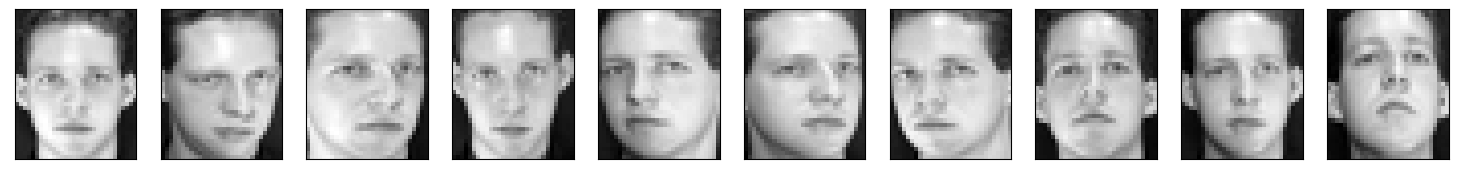

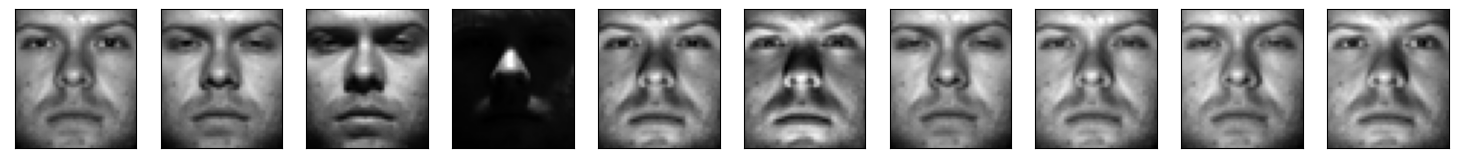

In [85]:
plt.figure(figsize=(18.5, 15))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_ORL[:,i].reshape(37,30), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
print(X_ORL.shape)

plt.figure(figsize=(18.5, 15))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_YaleB[:,i].reshape(48,42), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
print(X_YaleB.shape)

# Learn the model with noise

## $L_2$-Norm Based NMF

In [86]:
def experimentl2_NMF(X_ori,x_block,x_sp,y,nmf_run,exp_num=5):
    # X_ori: String, determine which dataset is inputed.
    # x_block: matrix, image with block noise added
    # x_sp: matrix, image with salt and pepper noise added
    # y: label of the inputed image
    # nmf_run: integer, number of iteration for the nmf update.
    # exp_num: integer, number of experiment
    
    #set up the randomstate
    rng = np.random.RandomState(1)
    for i in range(exp_num):
        print("current run {}".format(i+1))
        # separate the dataset based on the argument X_ori
        if X_ori =="X_ORL":
            #experiment for block noise
            # getting the 90% random sample
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_ORL)
            N_ORL = len(sample_block)
            M_ORL = len(sample_block[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            #update function and retrive the W,H component and the metrics
            l2_W_estimate_b, l2_H_estimate_b , l2_rre_metric,l2_acc_metric,l2_nmi_metric = L2_mf_multiplicative_update(sample_ori_b,sample_block,Y_sample_block, W, H, nmf_run)
            # plot out the metrics versus the step
            plot_metrics(l2_rre_metric,l2_acc_metric,l2_nmi_metric)  
            print("Evaluetion of block noised image")
            # print out the final evaluation based on the reconstructed image.
            evaluation(sample_ori_b, Y_sample_block,l2_W_estimate_b, l2_H_estimate_b)   

            #experiment for salt and pepper noise
            # getting the 90% random sample
            sample_salt_pepper,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_ORL)
            N_ORL = len(sample_salt_pepper)
            M_ORL = len(sample_salt_pepper[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            #update function and retrive the W,H component and the metrics
            l2_W_estimate_sp, l2_H_estimate_sp , l2_rre_metric,l2_acc_metric,l2_nmi_metric = L2_mf_multiplicative_update(sample_ori_sp,sample_salt_pepper,Y_sample_sp, W, H,nmf_run)
            # plot out the metrics versus the step
            plot_metrics(l2_rre_metric,l2_acc_metric,l2_nmi_metric) 
            print("Evaluetion of salt and peppered image")
            # print out the final evaluation based on the reconstructed image.
            evaluation(sample_ori_sp, Y_sample_sp,l2_W_estimate_sp, l2_H_estimate_sp)
            print("\n")
        elif X_ori =="X_YaleB":
            #experiment for block noise
            # getting the 90% random sample
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_YaleB)
            N_ORL = len(sample_block)
            M_ORL = len(sample_block[0])
            #experiment for block noise
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            #update function and retrive the W,H component and the metrics
            l2_W_estimate_b, l2_H_estimate_b , l2_rre_metric,l2_acc_metric,l2_nmi_metric = L2_mf_multiplicative_update(sample_ori_b,sample_block,Y_sample_block, W, H,nmf_run)
            plot_metrics(l2_rre_metric,l2_acc_metric,l2_nmi_metric)  
            print("Evaluetion of block noised image")
            evaluation(sample_ori_b, Y_sample_block,l2_W_estimate_b, l2_H_estimate_b)   

            #experiment for salt and pepper noise
            # getting the 90% random sample
            sample_salt_pepper,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_YaleB)
            N_ORL = len(sample_salt_pepper)
            M_ORL = len(sample_salt_pepper[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            #update function and retrive the W,H component and the metrics
            l2_W_estimate_sp, l2_H_estimate_sp , l2_rre_metric,l2_acc_metric,l2_nmi_metric = L2_mf_multiplicative_update(sample_ori_sp,sample_salt_pepper,Y_sample_sp, W, H,nmf_run)
            # plot out the metrics versus the step
            plot_metrics(l2_rre_metric,l2_acc_metric,l2_nmi_metric) 
            print("Evaluetion of salt and peppered image")
            # print out the final evaluation based on the reconstructed image.
            evaluation(sample_ori_sp, Y_sample_sp,l2_W_estimate_sp, l2_H_estimate_sp)
            print("\n")
    return l2_W_estimate_b, l2_H_estimate_b, l2_W_estimate_sp, l2_H_estimate_sp,sample_ori_b,sample_ori_sp

## $L_{2,1}$-Norm Based NMF

In [87]:
def experimentl21_NMF(X_ori,x_block,x_sp,y,nmf_run,exp_num=5):
    # X_ori: String, determine which dataset is inputed.
    # x_block: matrix, image with block noise added
    # x_sp: matrix, image with salt and pepper noise added
    # y: label of the inputed image
    # nmf_run: integer, number of iteration for the nmf update.
    # exp_num: integer, number of experiment
    
    #other incode references please refer to the L2 norm experiment function above
    
    #set up the randomstate
    rng = np.random.RandomState(1)
    for i in range(exp_num):
        print("current run {}".format(i+1))
        if X_ori =="X_ORL":
            #experiment for block noise
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_ORL)
            N_ORL = len(sample_block)
            M_ORL = len(sample_block[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            l21_W_estimate_b, l21_H_estimate_b , l21_rre_metric,l21_acc_metric,l21_nmi_metric = L21_mf_multiplicative_update(sample_ori_b,sample_block,Y_sample_block, W, H, nmf_run)
            plot_metrics(l21_rre_metric,l21_acc_metric,l21_nmi_metric)  
            print("Evaluetion of block noised image")
            evaluation(sample_ori_b, Y_sample_block,l21_W_estimate_b, l21_H_estimate_b)   

            #experiment for salt and pepper noise
            sample_salt_pepper,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_ORL)
            N_ORL = len(sample_salt_pepper)
            M_ORL = len(sample_salt_pepper[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            l21_W_estimate_sp, l21_H_estimate_sp , l21_rre_metric,l21_acc_metric,l21_nmi_metric = L21_mf_multiplicative_update(sample_ori_sp,sample_salt_pepper,Y_sample_sp, W, H,nmf_run)
            plot_metrics(l21_rre_metric,l21_acc_metric,l21_nmi_metric) 
            print("Evaluetion of salt and peppered image")
            evaluation(sample_ori_sp, Y_sample_sp,l21_W_estimate_sp, l21_H_estimate_sp)
            print("\n")
            
        elif X_ori =="X_YaleB":
            #experiment for block noise
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_YaleB)
            N_ORL = len(sample_block)
            M_ORL = len(sample_block[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            l21_W_estimate_b, l21_H_estimate_b , l21_rre_metric,l21_acc_metric,l21_nmi_metric = L21_mf_multiplicative_update(sample_ori_b,sample_block,Y_sample_block, W, H,nmf_run)
            plot_metrics(l21_rre_metric,l21_acc_metric,l21_nmi_metric)  
            print("Evaluetion of block noised image")
            evaluation(sample_ori_b, Y_sample_block,l21_W_estimate_b, l21_H_estimate_b)   

            #experiment for salt and pepper noise
            sample_salt_pepper,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_YaleB)
            N_ORL = len(sample_salt_pepper)
            M_ORL = len(sample_salt_pepper[0])
            W = rng.rand(N_ORL,K)
            H = rng.rand(K,M_ORL)
            l21_W_estimate_sp, l21_H_estimate_sp , l21_rre_metric,l21_acc_metric,l21_nmi_metric = L21_mf_multiplicative_update(sample_ori_sp,sample_salt_pepper,Y_sample_sp, W, H,nmf_run)
            plot_metrics(l21_rre_metric,l21_acc_metric,l21_nmi_metric) 
            print("Evaluetion of salt and peppered image")
            evaluation(sample_ori_sp, Y_sample_sp,l21_W_estimate_sp, l21_H_estimate_sp)
            print("\n")
    return l21_W_estimate_b, l21_H_estimate_b, l21_W_estimate_sp, l21_H_estimate_sp,sample_ori_b,sample_ori_sp

## CIM Non-negative Matrix Factorization 

In [88]:
def experiment_CIM_NMF(x_block,x_sp,y,exp_num=5, data = "ORL"):
    for i in range(exp_num):
        print("current run {}".format(i+1))
        #resample 90% of image
        if data == "ORL":
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_ORL)
            sample_sp,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_ORL)
        else:
            sample_block,Y_sample_block,sample_ori_b = rand_sample(x_block,y,X_YaleB)
            sample_sp,Y_sample_sp,sample_ori_sp = rand_sample(x_sp,y,X_YaleB)

        nmf = CIM_NMF(K)
        #experiment for block noise
        W_estimate_block, H_estimate_block, rre_metric,acc_metric,nmi_metric = nmf.fit(sample_block,Y_sample_block)
        plot_metrics(rre_metric,acc_metric,nmi_metric)  
        print("Evaluetion of block noised image")
        evaluation(sample_ori_b, Y_sample_block,W_estimate_block, H_estimate_block)   
       
        nmf = CIM_NMF(K)
        #experiment for salt and pepper noise
        W_estimate_salt, H_estimate_salt, rre_metric,acc_metric,nmi_metric = nmf.fit(sample_sp,Y_sample_sp)
        plot_metrics(rre_metric,acc_metric,nmi_metric)
        print("Evaluetion of salt and peppered image")
        evaluation(sample_ori_sp, Y_sample_sp, W_estimate_salt, H_estimate_salt)   
        print("\n")
    return W_estimate_block, H_estimate_block, W_estimate_salt, H_estimate_salt, sample_ori_b,sample_ori_sp

In [89]:
K=100

# First attempt

## Adding noise to the image

### Block noise

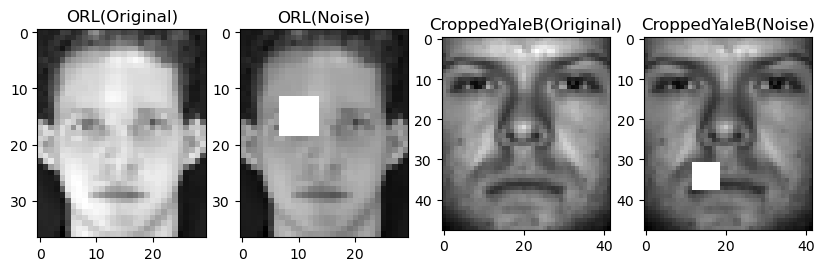

In [90]:
# block
data_orl = 'ORL'
X_ORL_block_noise = add_block_occlusion_noise(X_ORL, data_orl,7)
data_yaleb = 'CroppedYaleB'
X_YaleB_block_noise = add_block_occlusion_noise(X_YaleB, data_yaleb,7)

plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(X_ORL[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(X_ORL_block_noise[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Noise)')
plt.subplot(143)
plt.imshow(X_YaleB[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original)')
plt.subplot(144)
plt.imshow(X_YaleB_block_noise[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Noise)')
plt.show()

### Salt and pepper

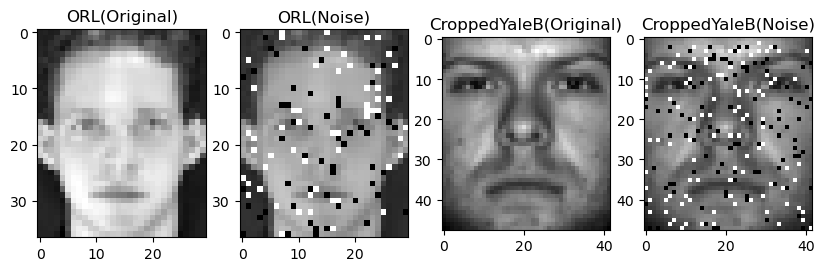

In [91]:
#salt and pepper
X_ORL_salt_pepper_noise = add_salt_pepper_noise(X_ORL,0.1)
X_YaleB_salt_pepper_noise = add_salt_pepper_noise(X_YaleB,0.1)

plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(X_ORL[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(X_ORL_salt_pepper_noise[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Noise)')
plt.subplot(143)
plt.imshow(X_YaleB[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original)')
plt.subplot(144)
plt.imshow(X_YaleB_salt_pepper_noise[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Noise)')
plt.show()

## $L_2$-Norm Based NMF

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23879799499787066
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5111 (0.6451)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2704450342057241
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4167 (0.5665)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23357867879744465
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4806 (0.6335)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.27109298060055076
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4000 (0.5697)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23730284979754107
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5083 (0.6679)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2609970089174887
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3611 (0.5343)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23243904587401765
==> Evaluate Acc and NMI ...


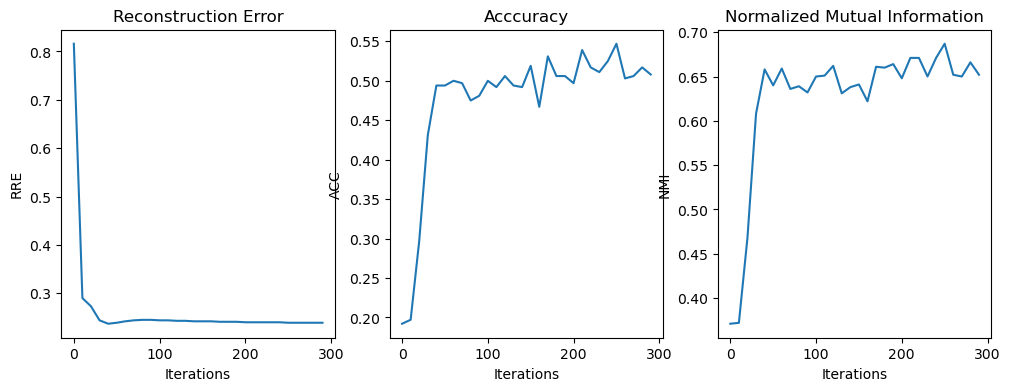

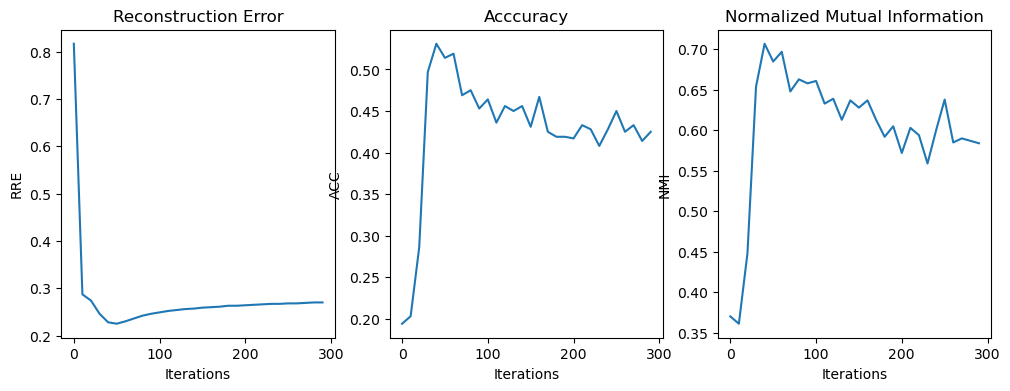

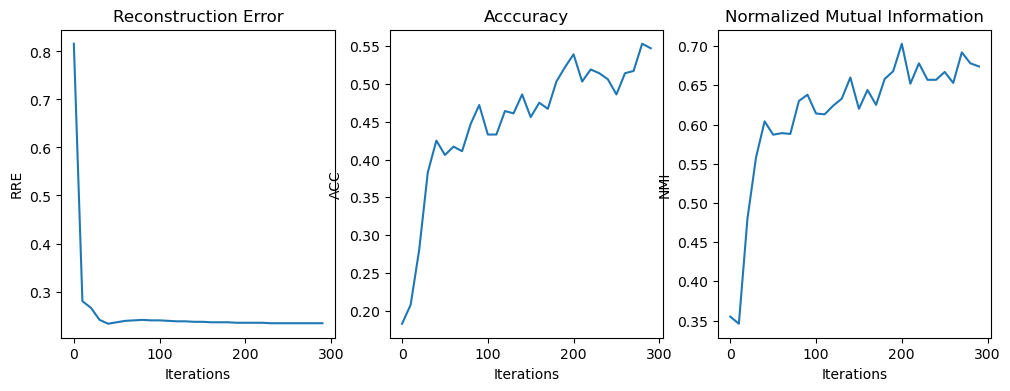

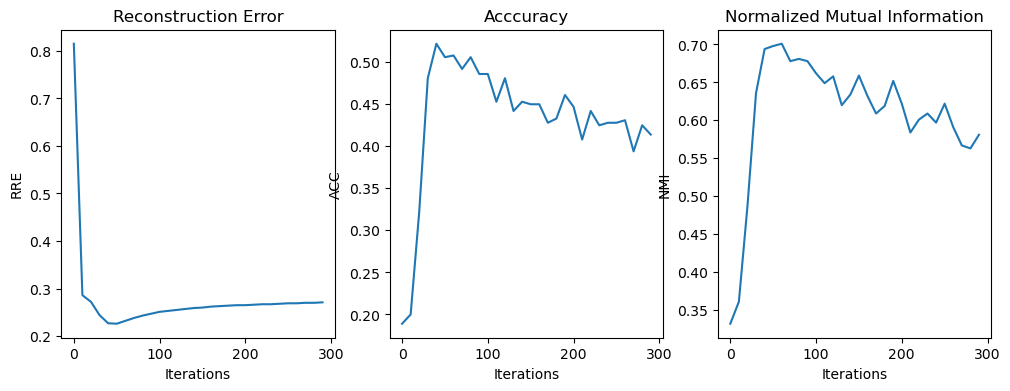

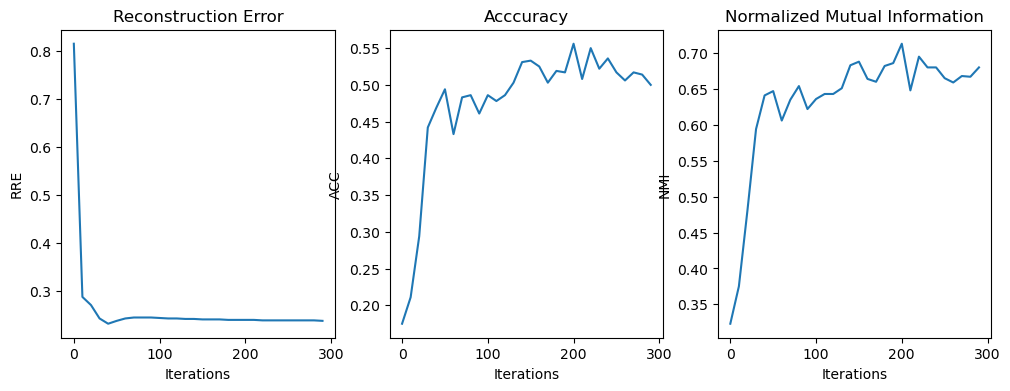

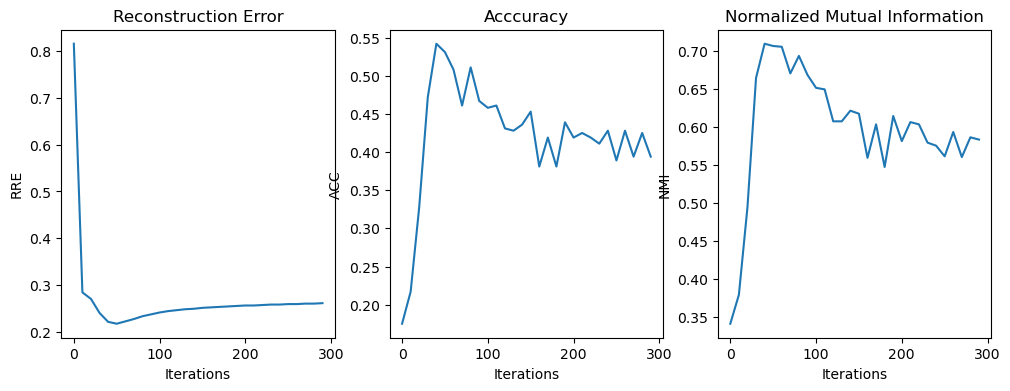

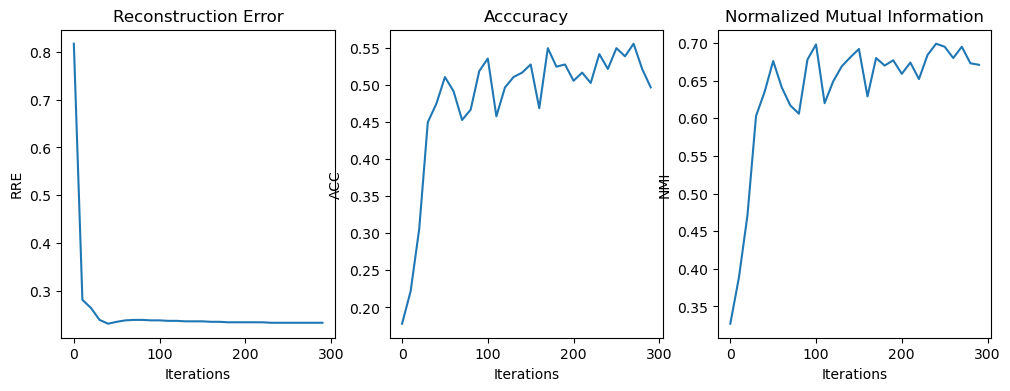

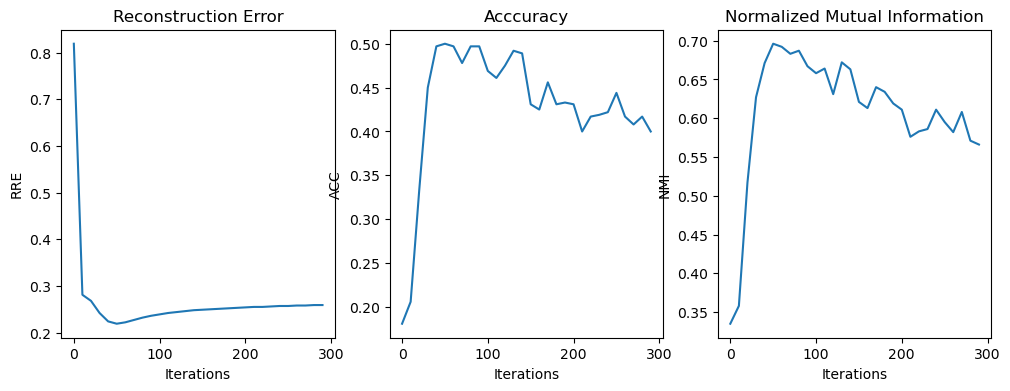

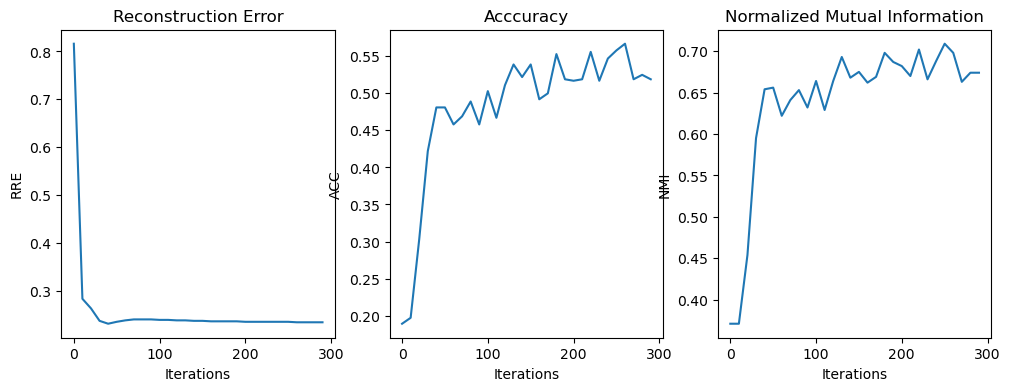

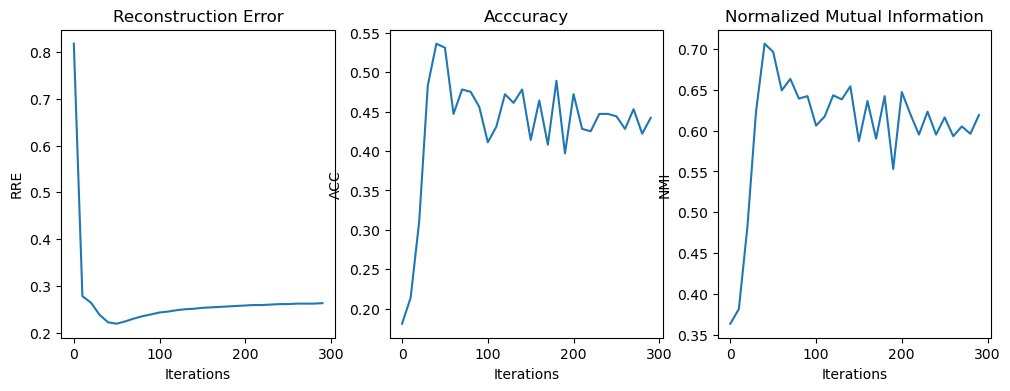

In [92]:
l2_W_estimate_b, l2_H_estimate_b, l2_W_estimate_sp, l2_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl2_NMF("X_ORL",X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL,300)

### Image of Original image and reconstructed image for both noised image

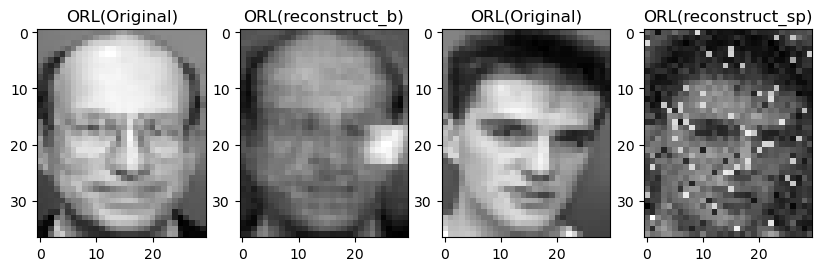

In [93]:
ORL_reconstruct_b=reconstruct(l2_W_estimate_b, l2_H_estimate_b)
ORL_reconstruct_sp=reconstruct(l2_W_estimate_sp, l2_H_estimate_sp)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
stoped step is: 275
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.31856728020837954
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2334 (0.3119)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.25370656658202106
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2104 (0.2760)


current run 2
stoped step is: 281
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.3212175976611929
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2366 (0.3192)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.25520068493122533
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1901 (0.2463)


current run 3
stoped step is: 255
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.31833676501333685
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2413 (0.3098)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2673014885806153
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1837 (0.2539)


current run 4
stoped step is: 274
Evaluetion of block noised im

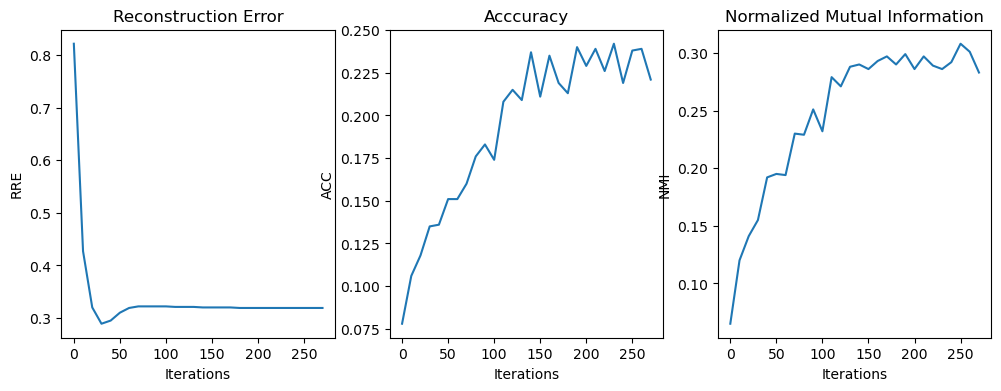

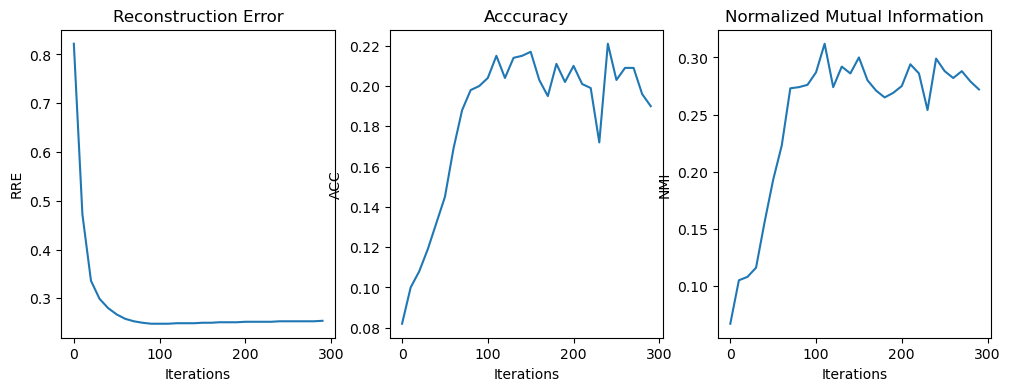

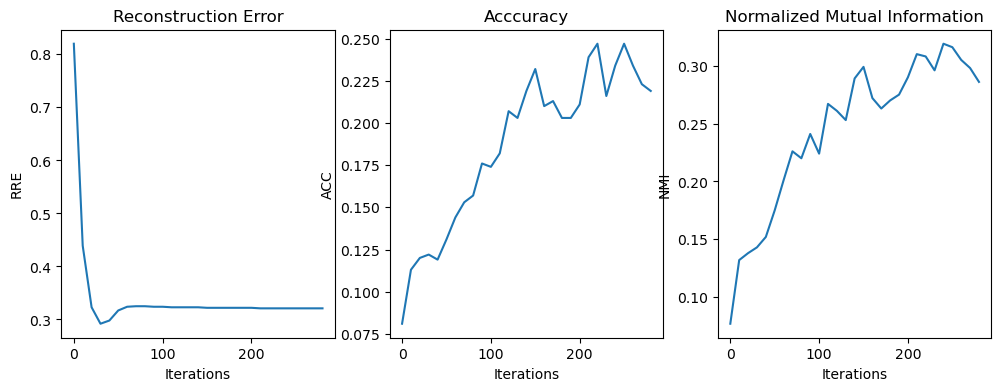

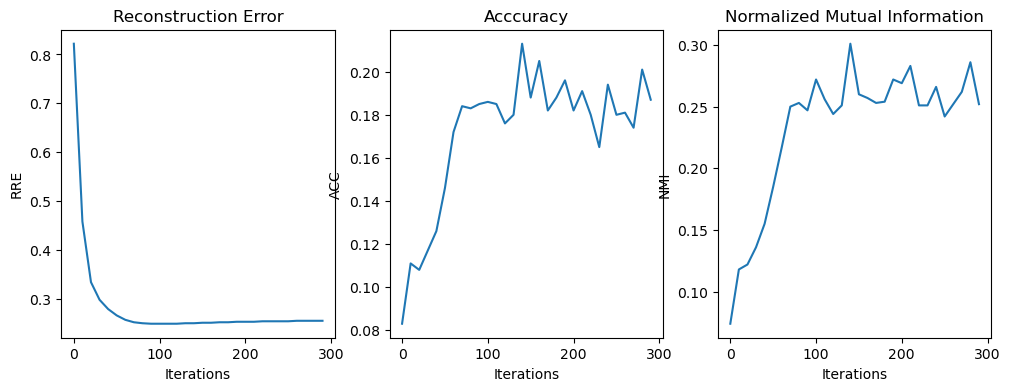

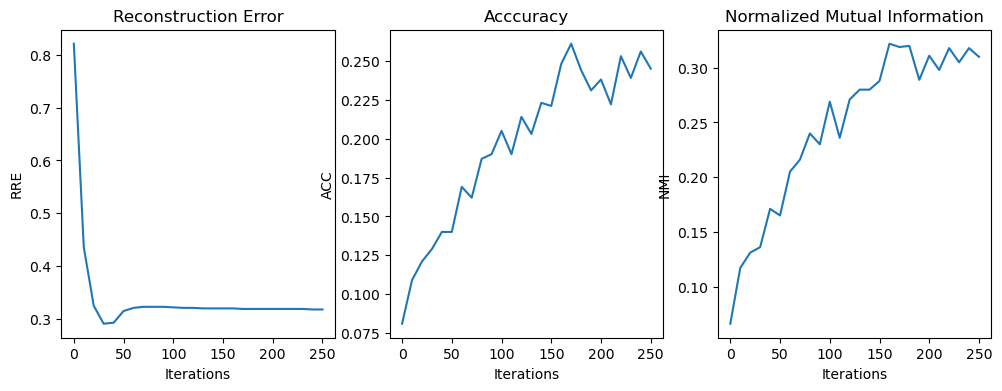

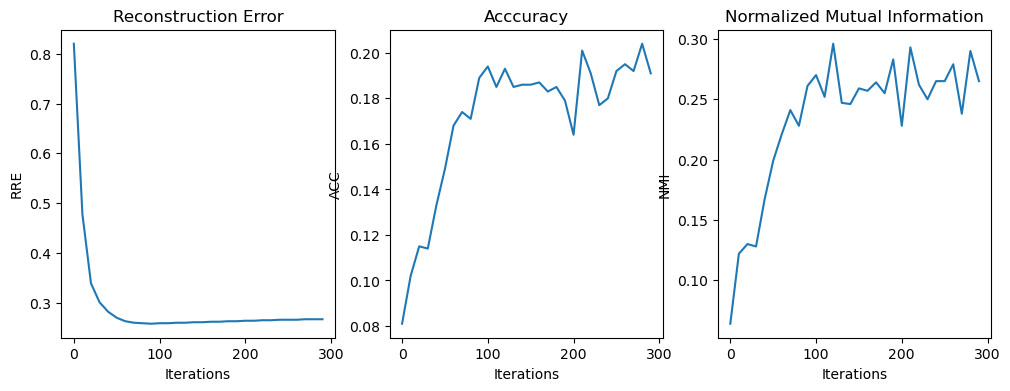

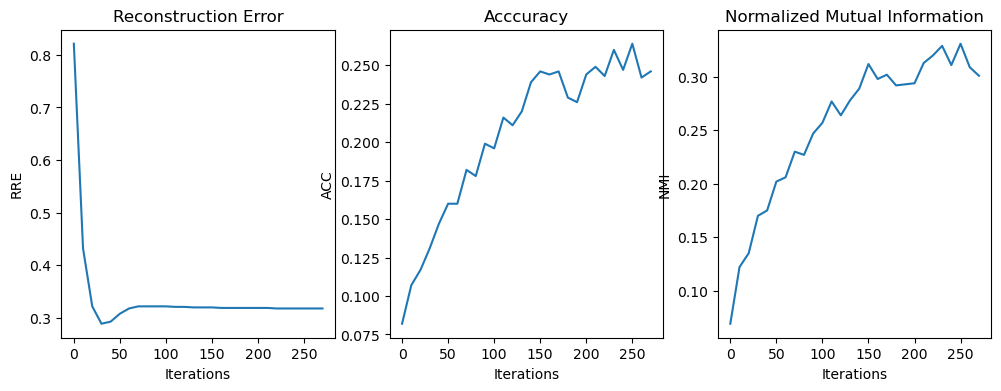

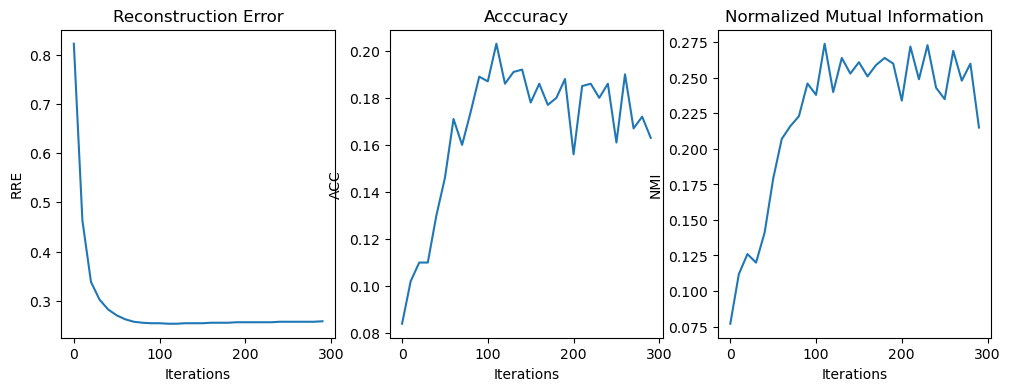

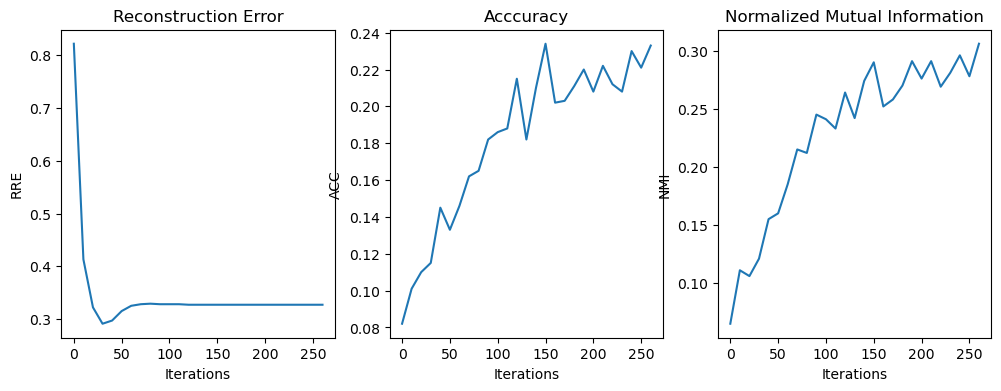

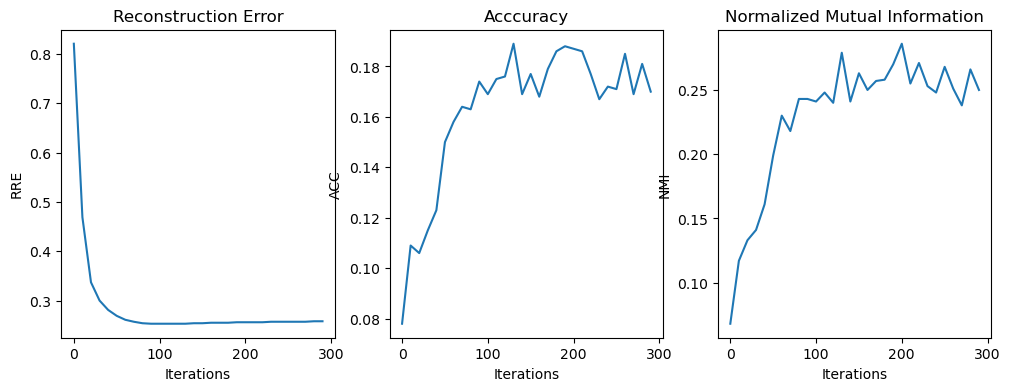

In [94]:
l2_W_estimate_b, l2_H_estimate_b, l2_W_estimate_sp, l2_H_estimate_sp,sample_ori_b,sample_ori_sp= experimentl2_NMF("X_YaleB",X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB,300)

### Image of Original image and reconstructed image for both noised image

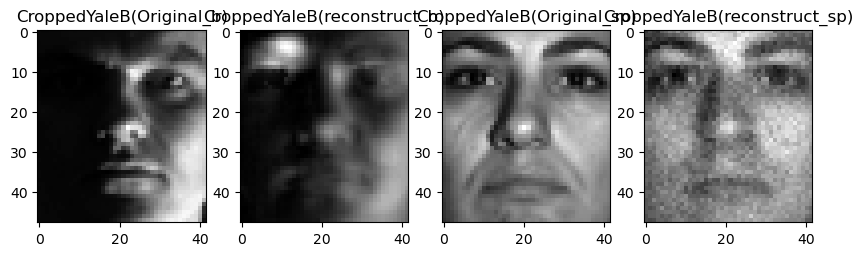

In [95]:
YaleB_reconstruct_b=reconstruct(l2_W_estimate_b, l2_H_estimate_b)
YaleB_reconstruct_sp=reconstruct(l2_W_estimate_sp, l2_H_estimate_sp)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(YaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(YaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()

## $L_{2,1}$-Norm Based NMF

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.24023905168279322
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5194 (0.6723)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.26863893455145366
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3722 (0.5739)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23590184482821944
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5861 (0.7214)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2675318279885685
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4028 (0.5977)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.2419643936031026
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5139 (0.6742)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.27200825851340177
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3889 (0.5649)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23712022454771303
==> Evaluate Acc and NMI ...


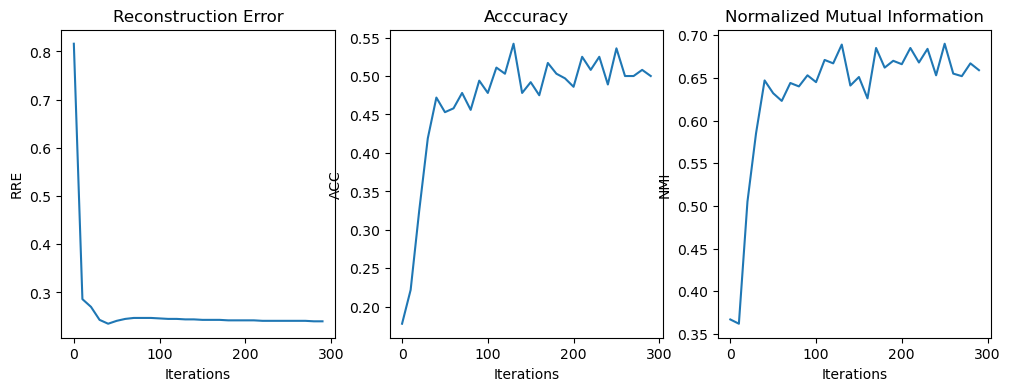

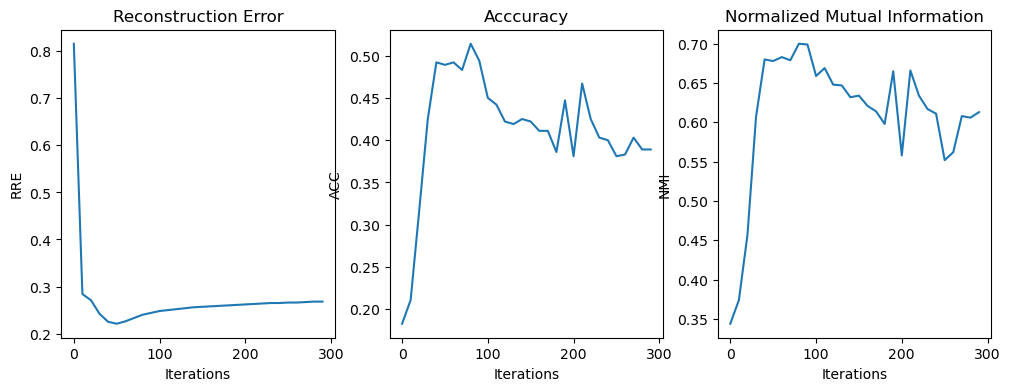

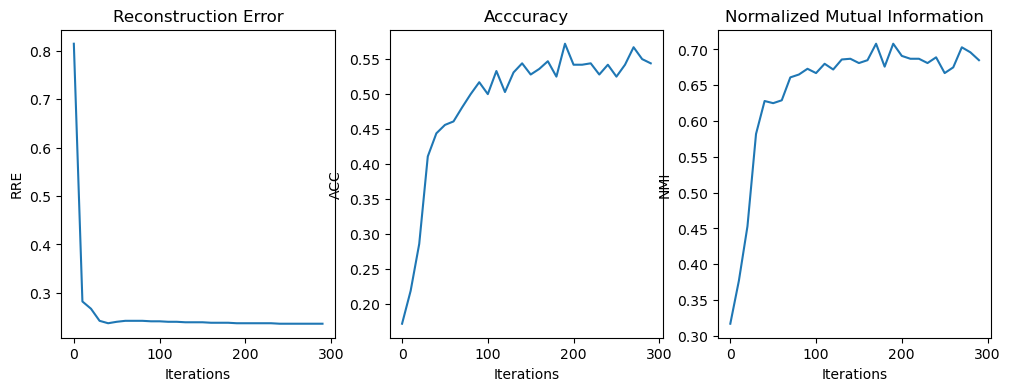

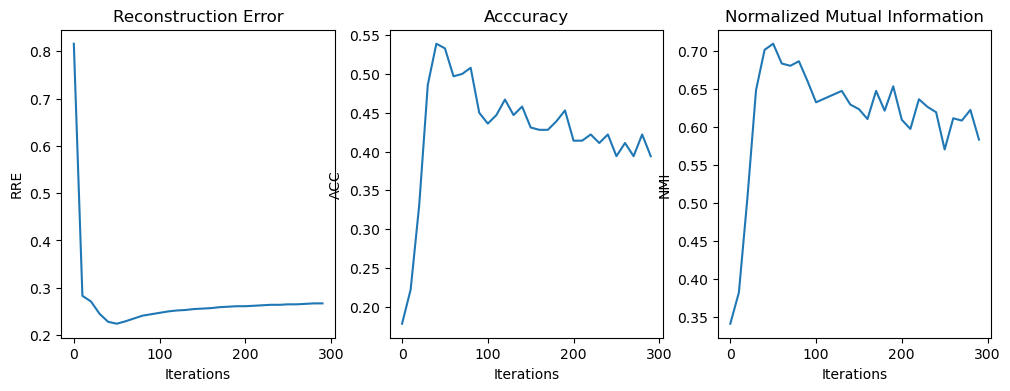

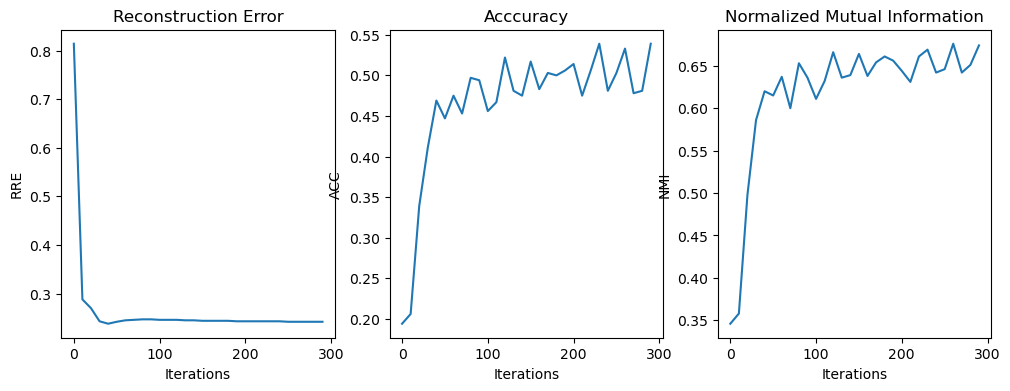

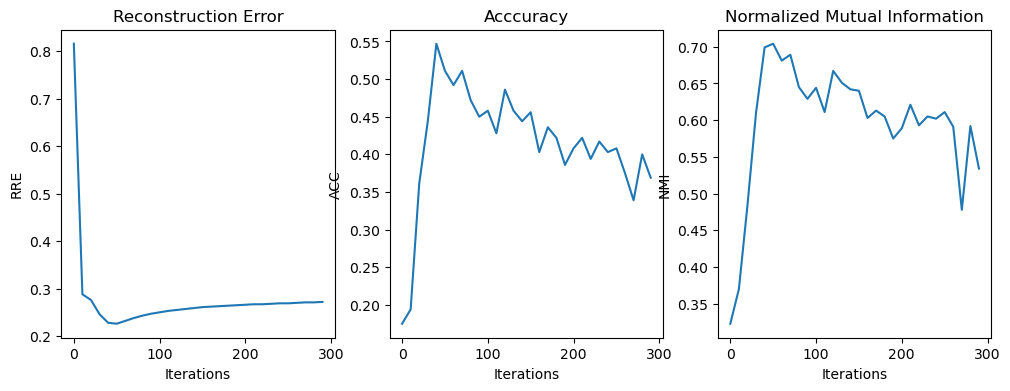

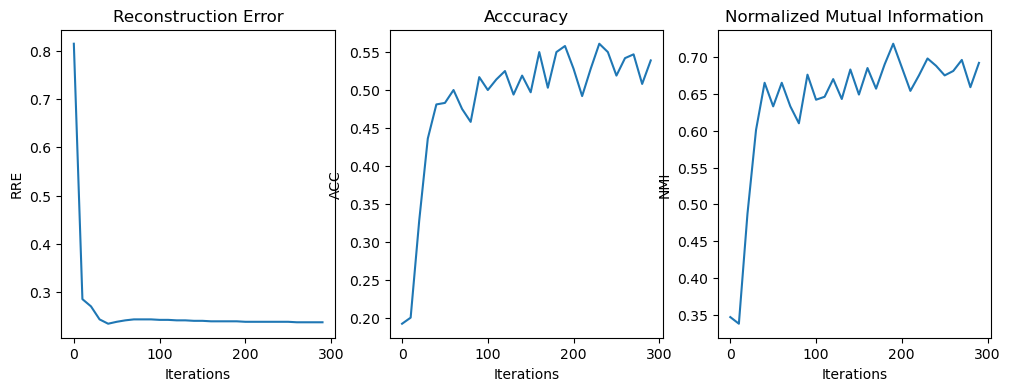

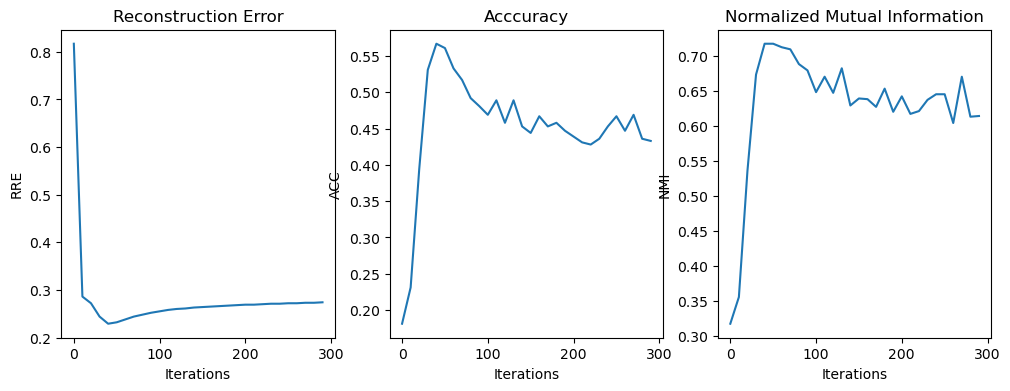

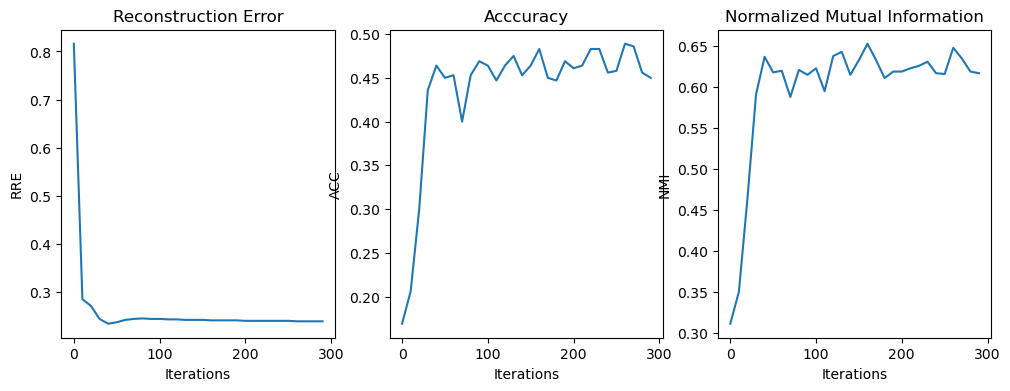

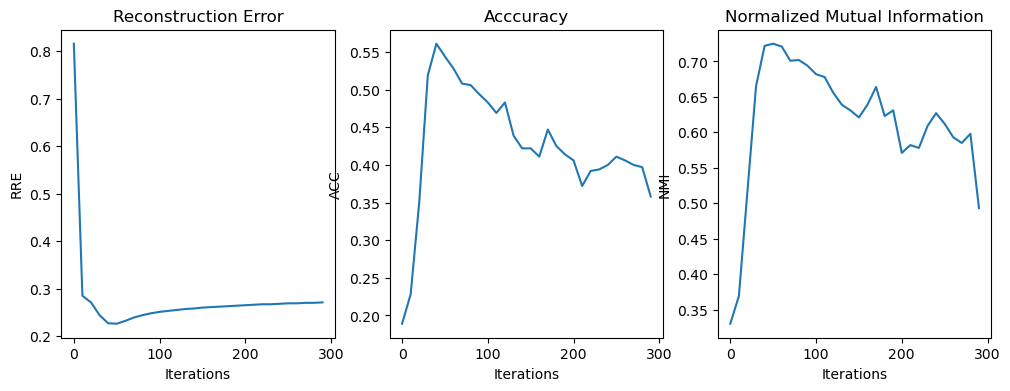

In [96]:
l21_W_estimate_b, l21_H_estimate_b, l21_W_estimate_sp, l21_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl21_NMF("X_ORL",X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL,300)

### Image of Original image and reconstructed image for both noised image

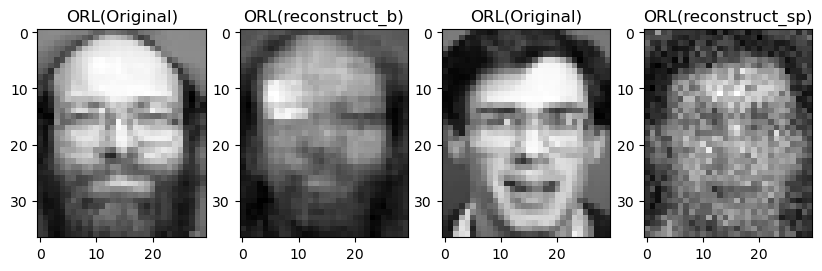

In [97]:
ORL_reconstruct_b=reconstruct(l21_W_estimate_b, l21_H_estimate_b)
ORL_reconstruct_sp=reconstruct(l21_W_estimate_sp, l21_H_estimate_sp)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.31454086322574254
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2371 (0.3193)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.27049417392628744
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1547 (0.2165)


current run 2
stoped step is: 293
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.3196908847070963
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2569 (0.3068)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2709383282080515
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1492 (0.1916)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.3198051287913071
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2712 (0.3296)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2644863646563263
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1556 (0.1932)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.31870330258556634
==> Evaluat

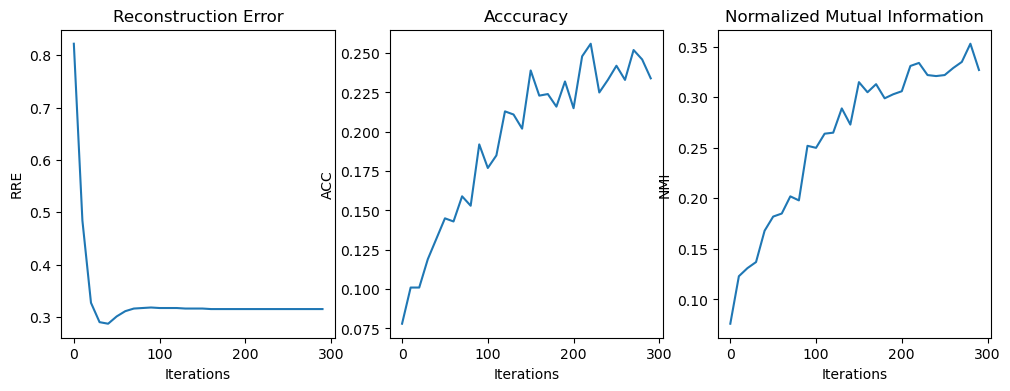

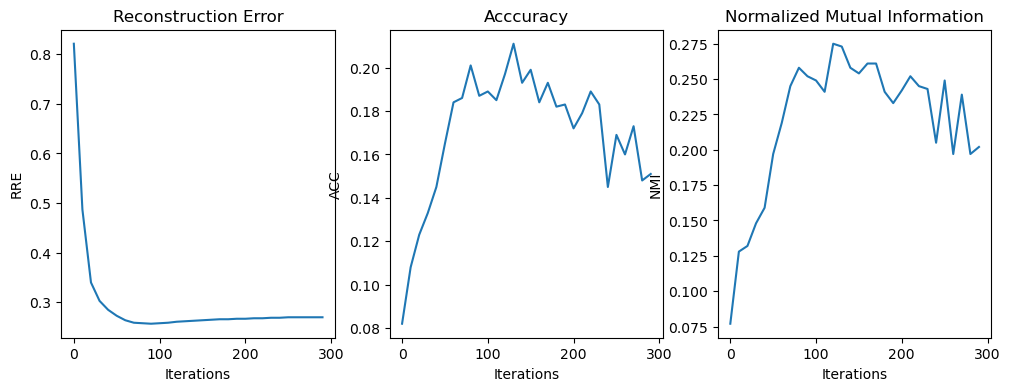

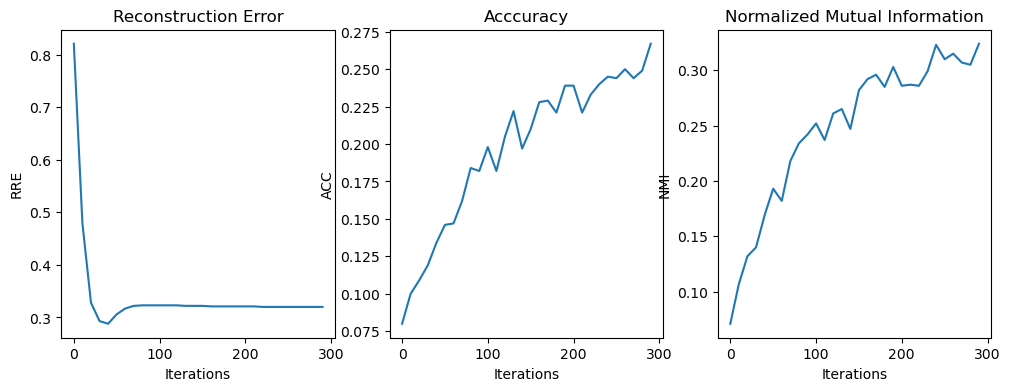

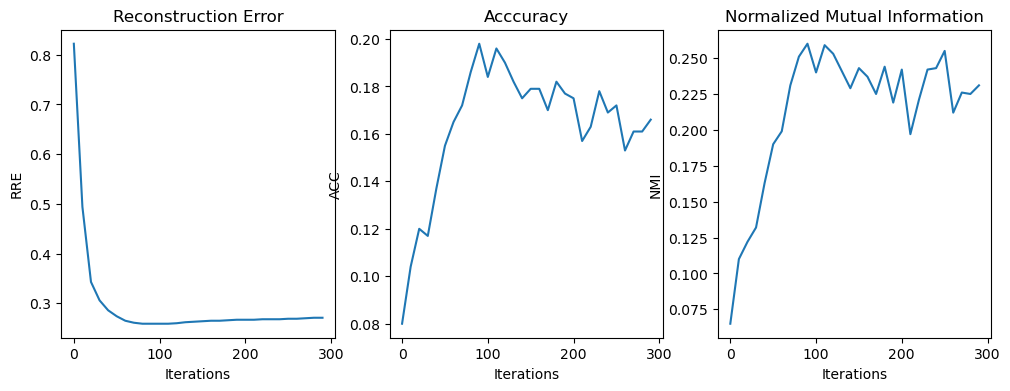

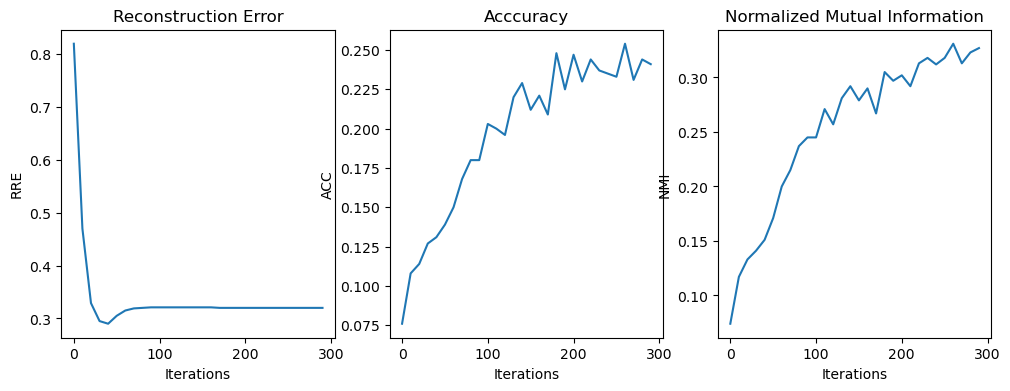

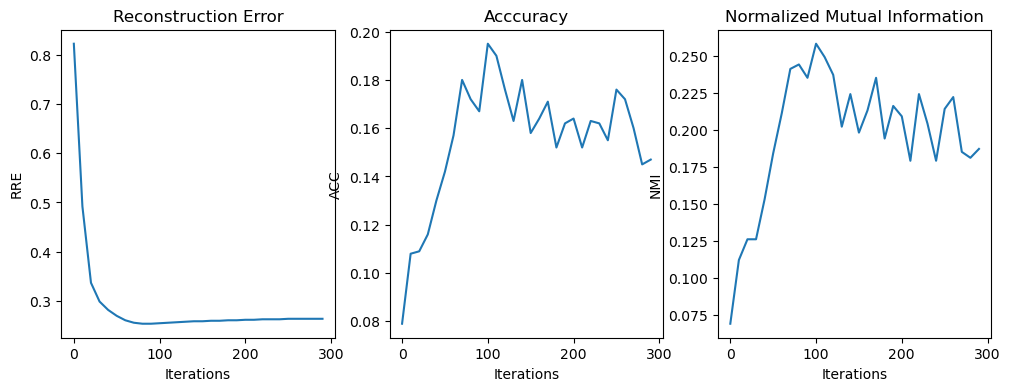

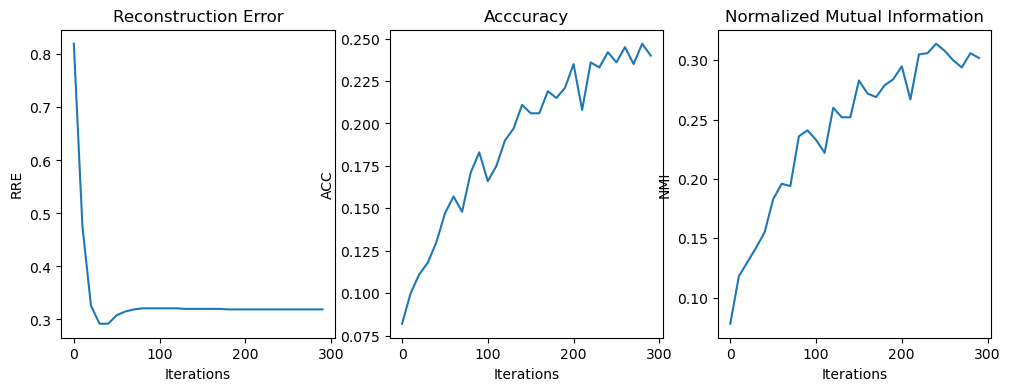

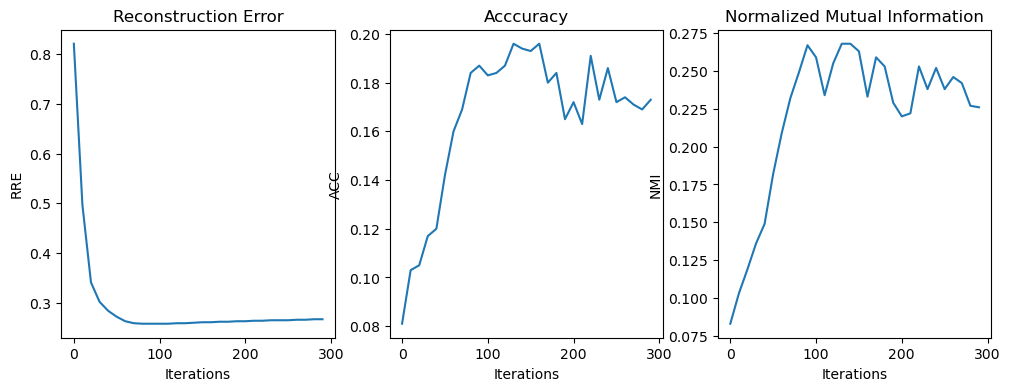

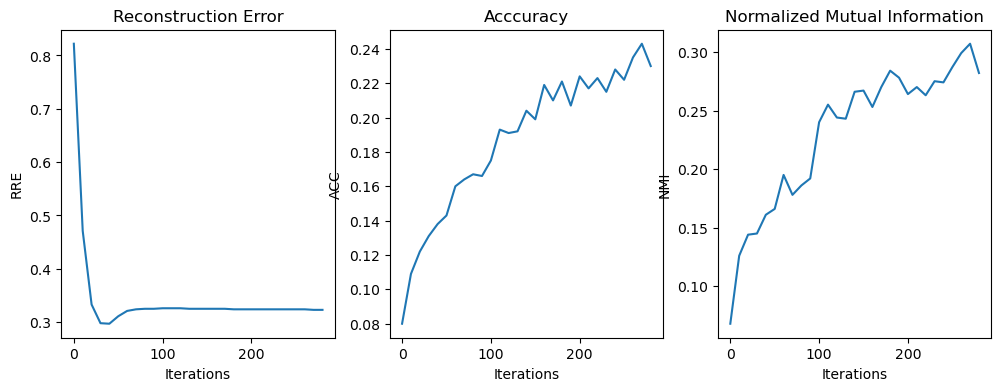

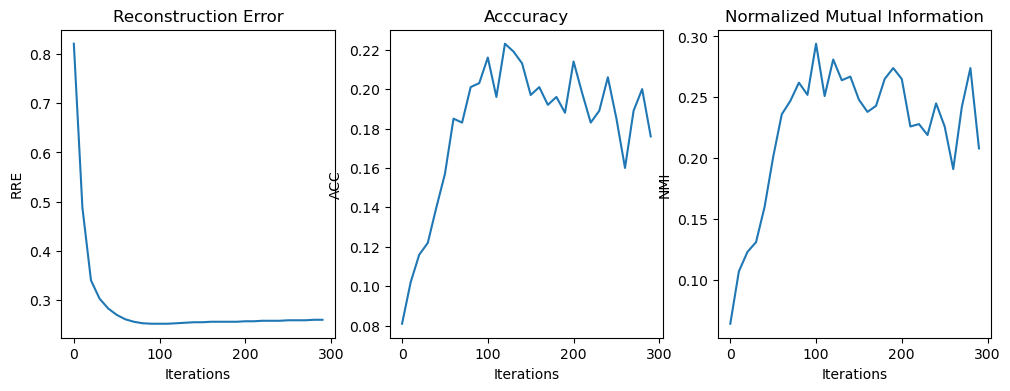

In [98]:
l21_W_estimate_b, l21_H_estimate_b, l21_W_estimate_sp, l21_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl21_NMF("X_YaleB",X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB,300)

### Image of Original image and reconstructed image for both noised image

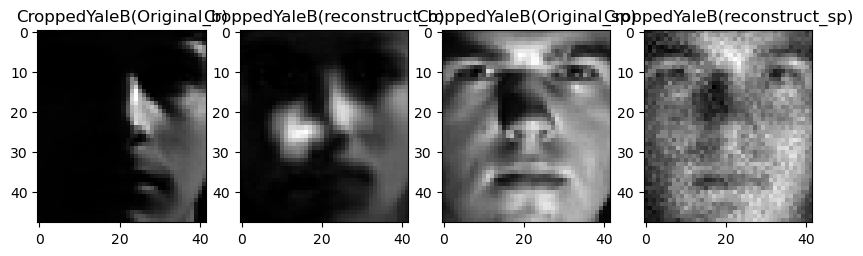

In [99]:
YaleB_reconstruct_b=reconstruct(l21_W_estimate_b, l21_H_estimate_b)
YaleB_reconstruct_sp=reconstruct(l21_W_estimate_sp, l21_H_estimate_sp)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(YaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(YaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()

## CIM Non-negative Matrix Factorization 

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.14458859374323552
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.7333 (0.8515)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.12144531792822544
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.7417 (0.8512)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.14674887239339512
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.6917 (0.8374)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.12336783791503464
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.7278 (0.8549)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.1458237399221255
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.7167 (0.8329)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.119615614337128
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.6917 (0.8182)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.14391714904095015
==> Evaluate Acc and NMI ...
A

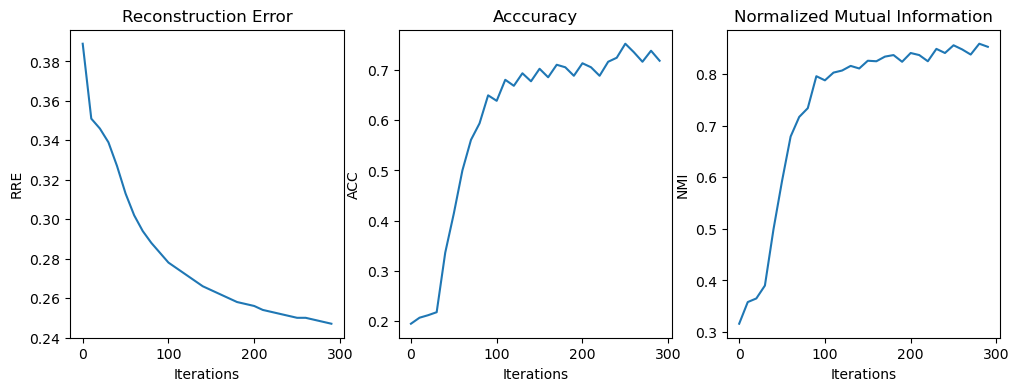

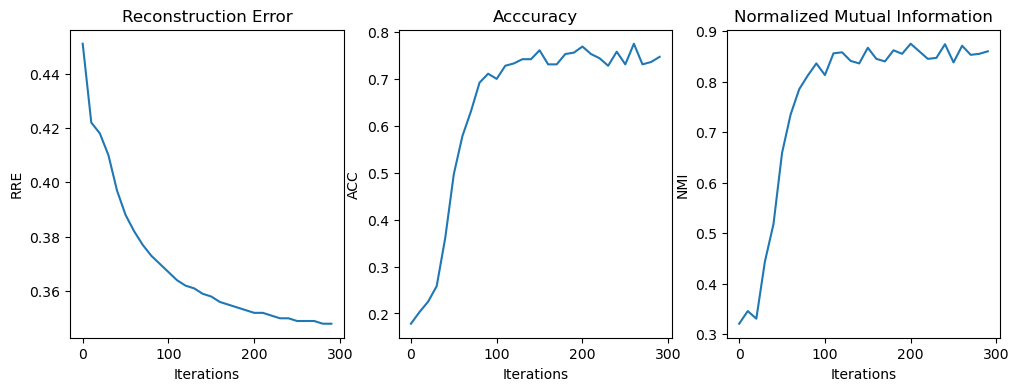

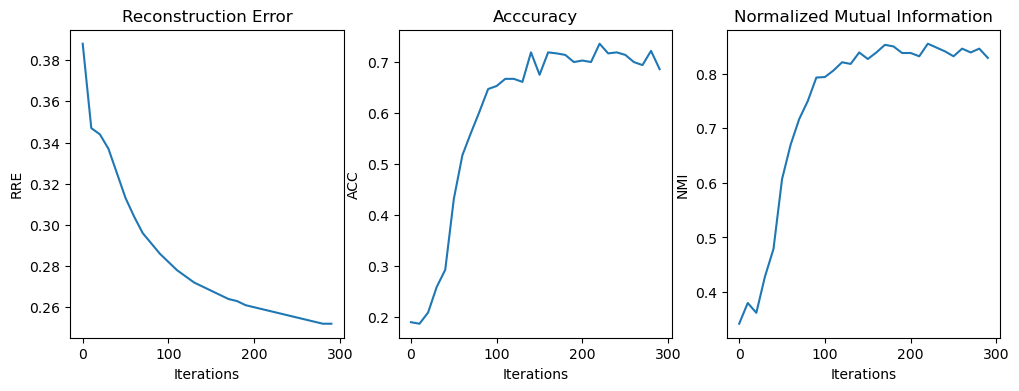

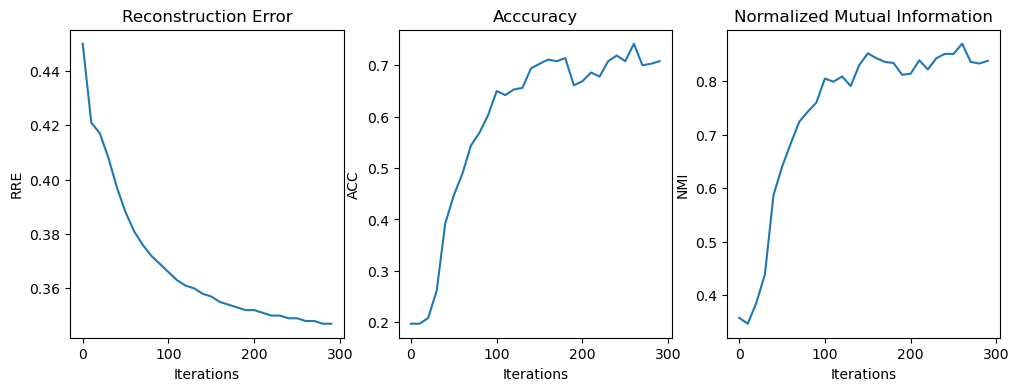

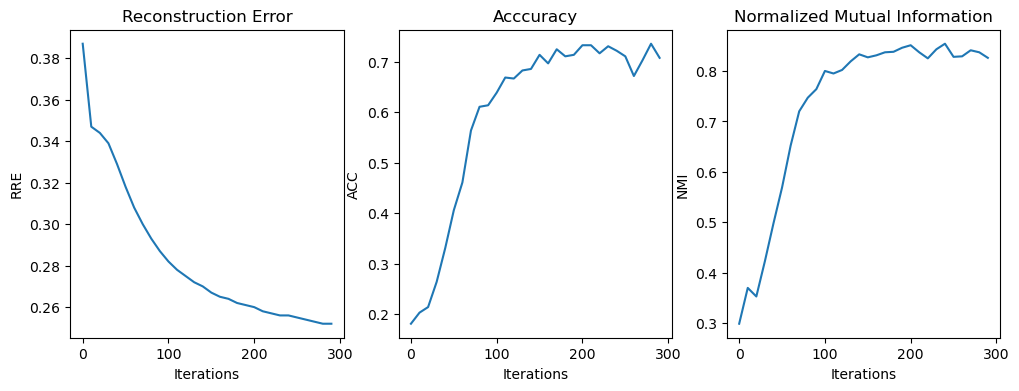

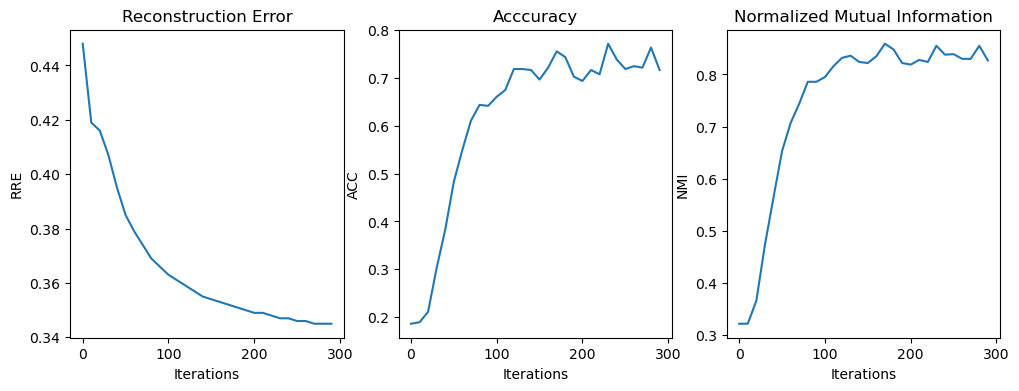

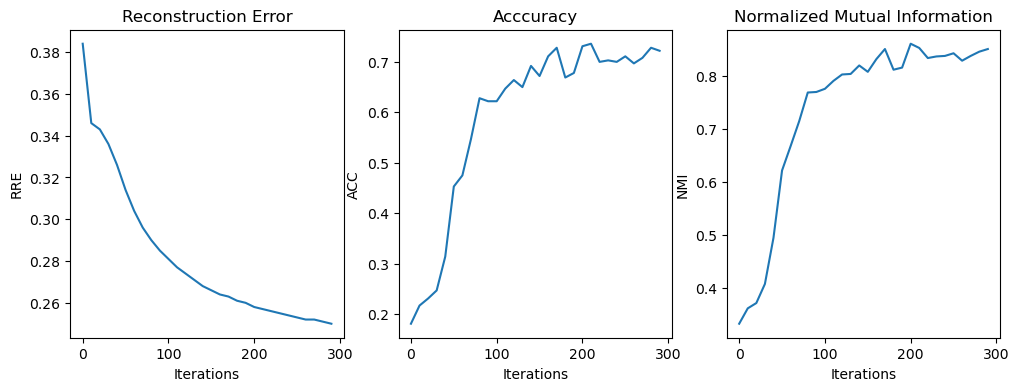

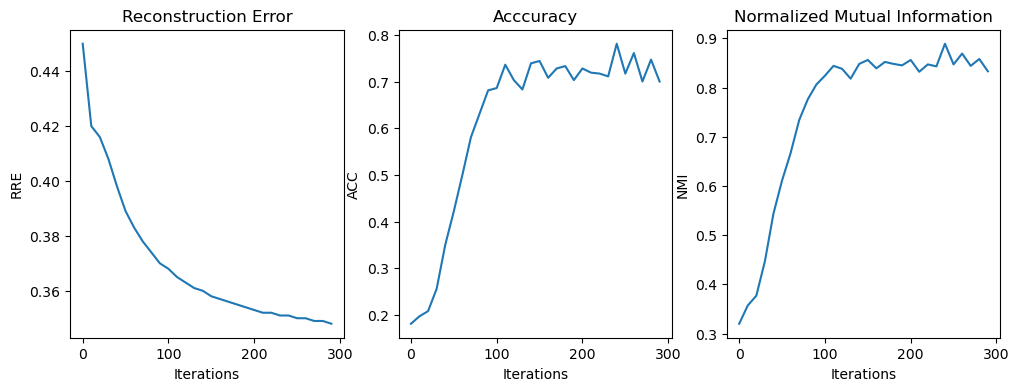

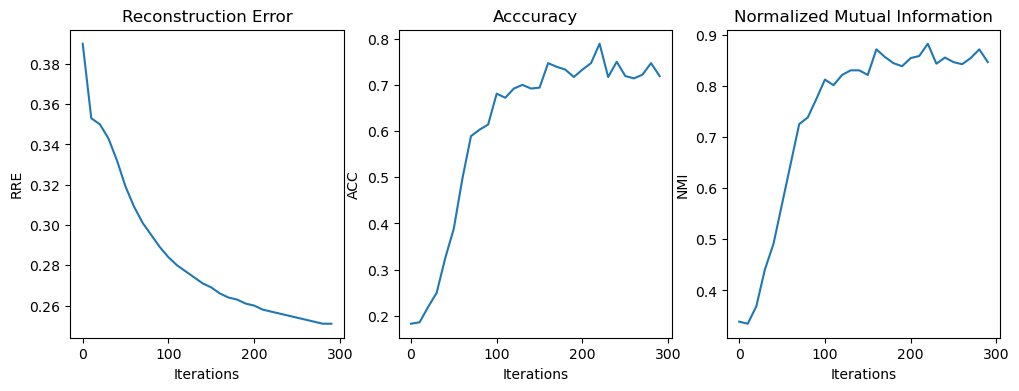

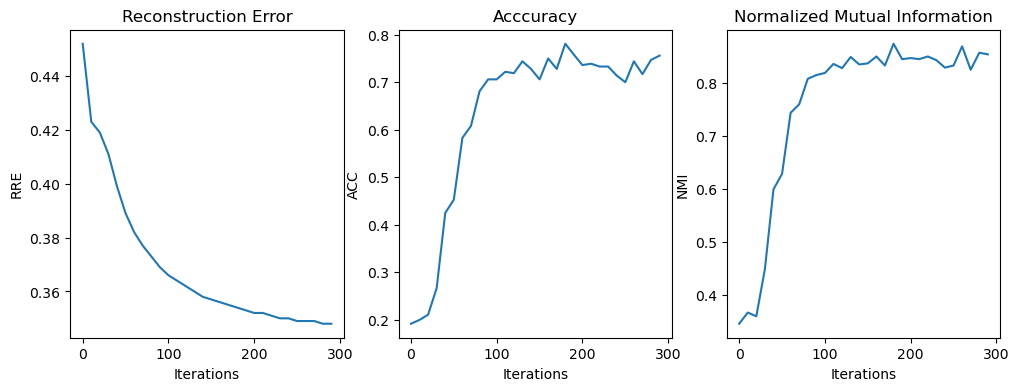

In [100]:
W_estimate_block, H_estimate_block, W_estimate_salt, H_estimate_salt, sample_ori_b,sample_ori_sp = experiment_CIM_NMF(
    X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL, data = "ORL")

### Image of Original image and reconstructed image for both noised image

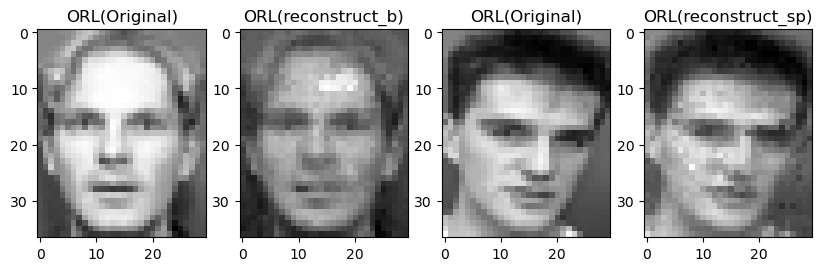

In [101]:
# show image for ORL
ORL_reconstruct_b=reconstruct(W_estimate_block, H_estimate_block)
ORL_reconstruct_sp=reconstruct(W_estimate_salt, H_estimate_salt)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.2070844317151836
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2546 (0.3150)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.18497144539271748
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2638 (0.3173)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.20790355487734669
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2799 (0.3155)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.18047523662804718
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2924 (0.3629)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.20862256085413888
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2739 (0.3422)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.18086560351323383
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3177 (0.3719)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.20609536521192912
==> Evaluate Acc and NMI ...

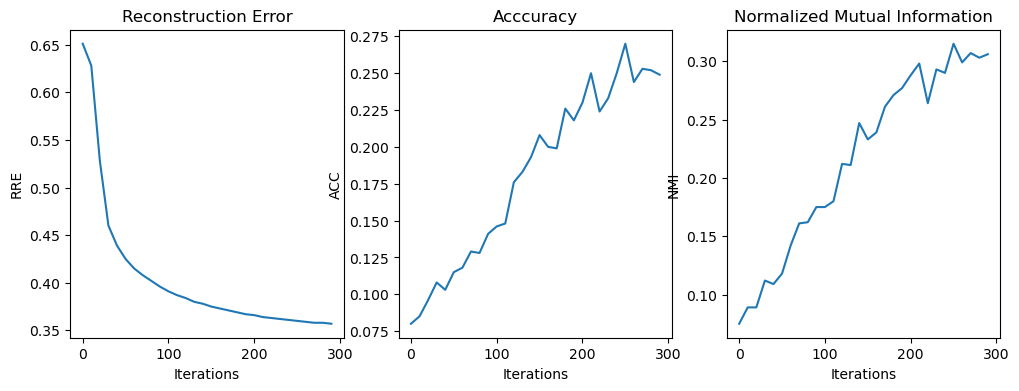

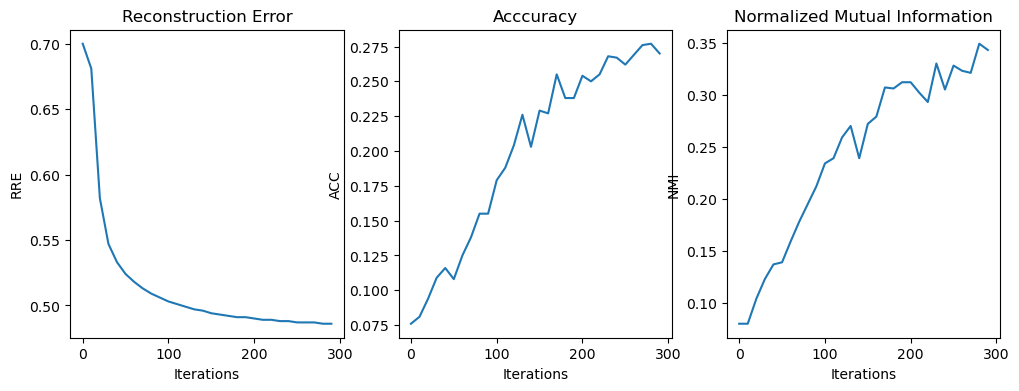

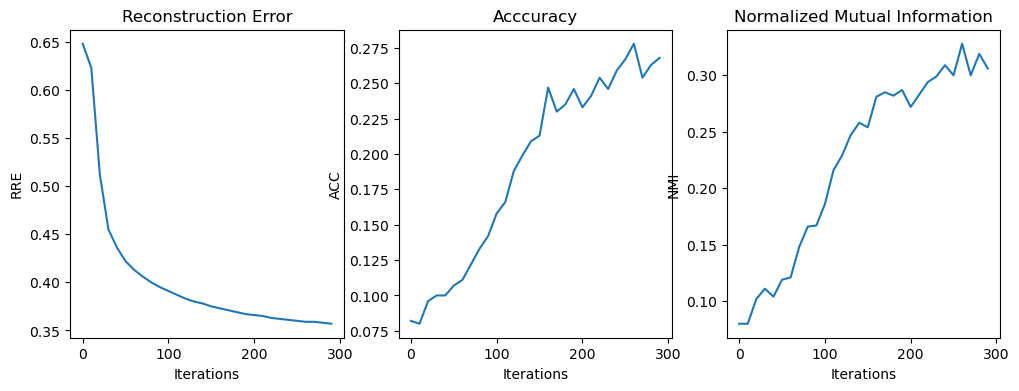

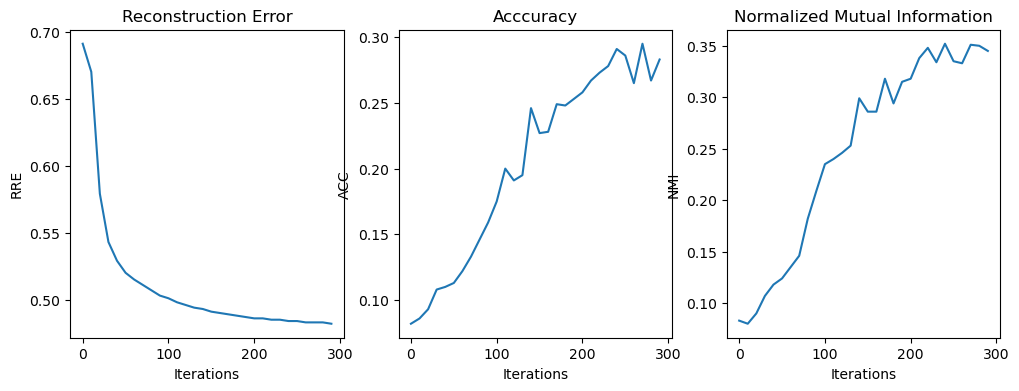

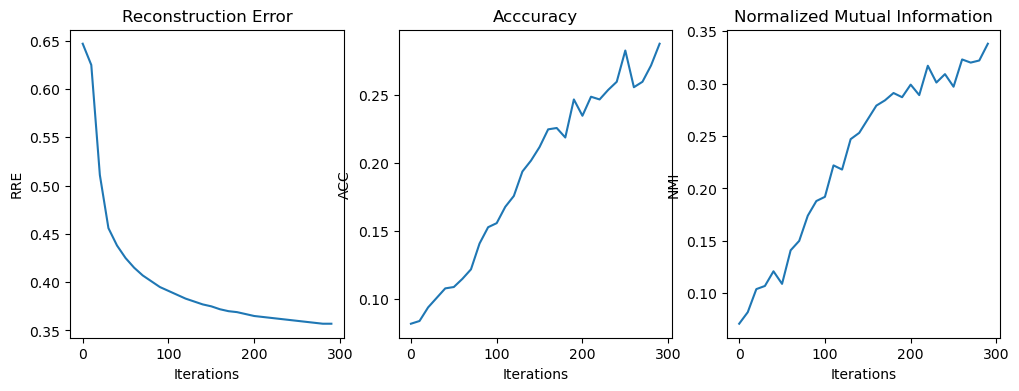

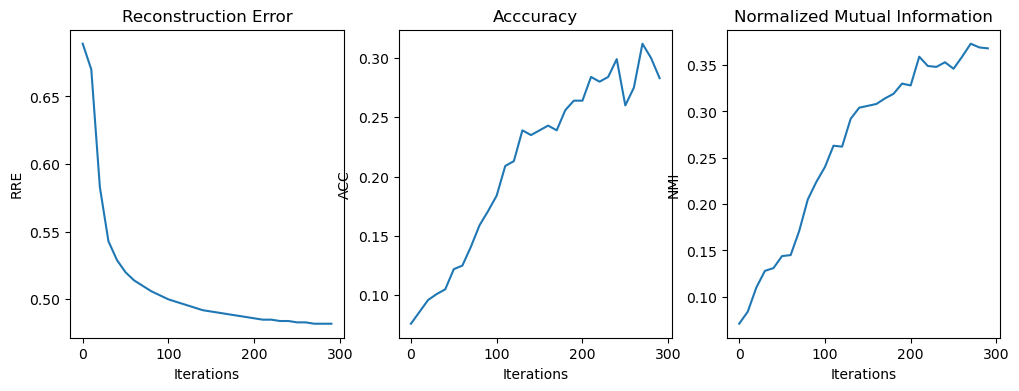

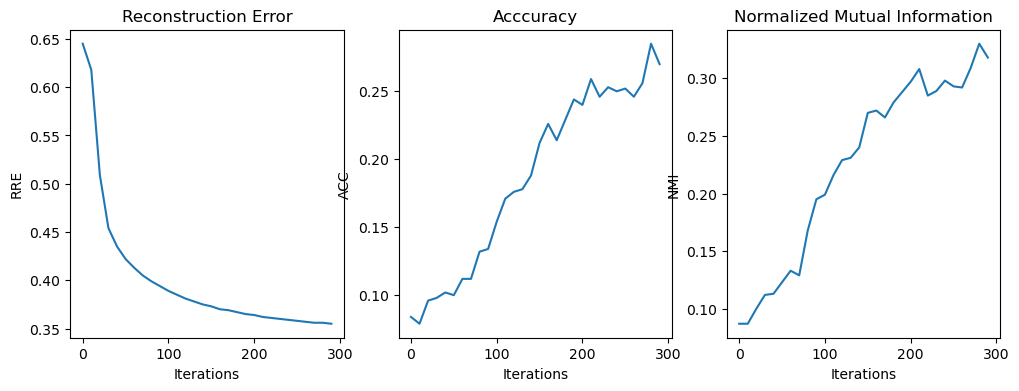

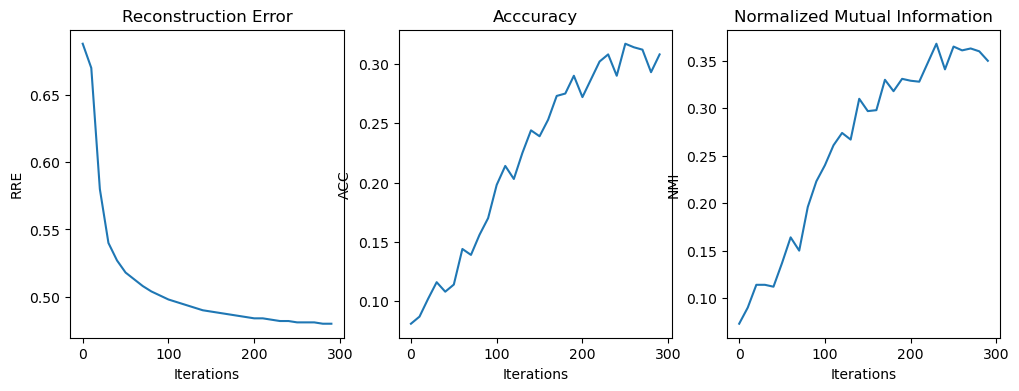

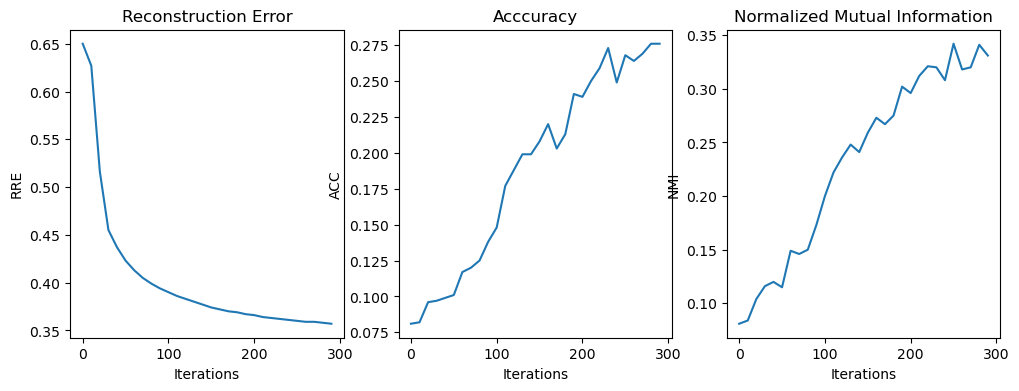

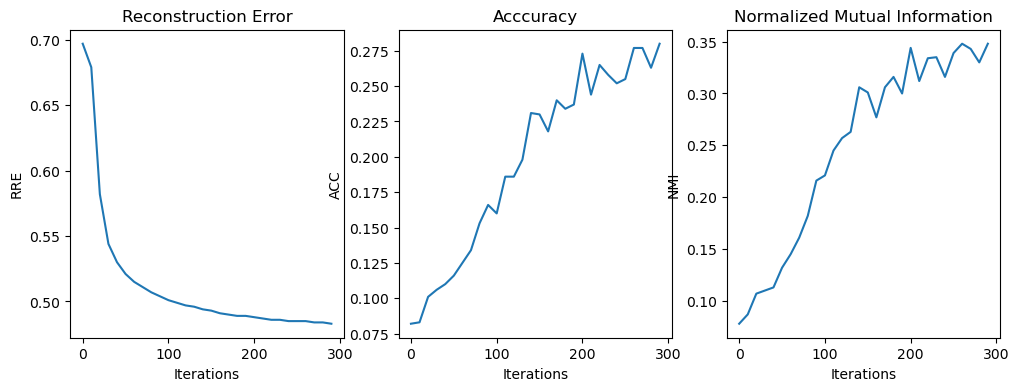

In [102]:
W_estimate_block, H_estimate_block, W_estimate_salt, H_estimate_salt,sample_ori_b,sample_ori_sp = experiment_CIM_NMF(
    X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB, data = "YaleB")

### Image of Original image and reconstructed image for both noised image

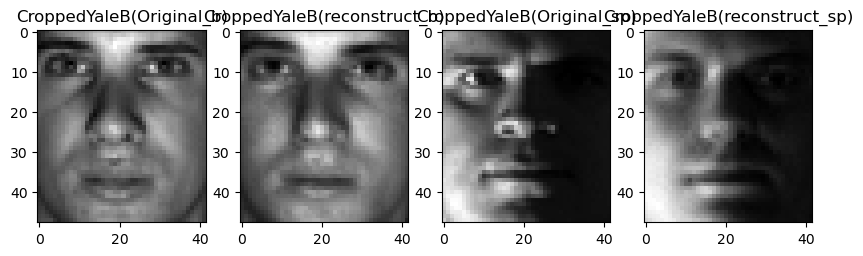

In [103]:
# show image for YaleB
yaleB_reconstruct_b=reconstruct(W_estimate_block, H_estimate_block)
yaleB_reconstruct_sp=reconstruct(W_estimate_salt, H_estimate_salt)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(yaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(yaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()

# Second attempt

## Adding noise to the image

### Block noise

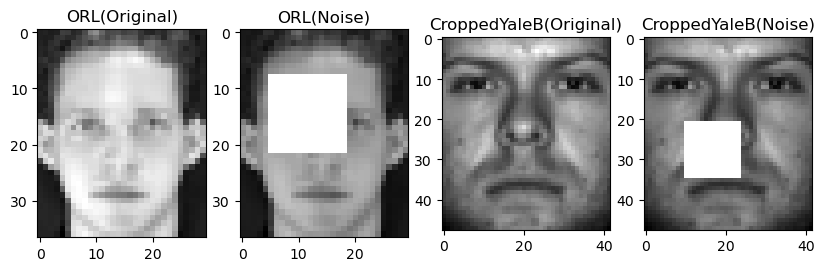

In [104]:
# block
data_orl = 'ORL'
X_ORL_block_noise = add_block_occlusion_noise(X_ORL, data_orl,14)
data_yaleb = 'CroppedYaleB'
X_YaleB_block_noise = add_block_occlusion_noise(X_YaleB, data_yaleb,14)

plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(X_ORL[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(X_ORL_block_noise[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Noise)')
plt.subplot(143)
plt.imshow(X_YaleB[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original)')
plt.subplot(144)
plt.imshow(X_YaleB_block_noise[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Noise)')
plt.show()

### Salt and pepper

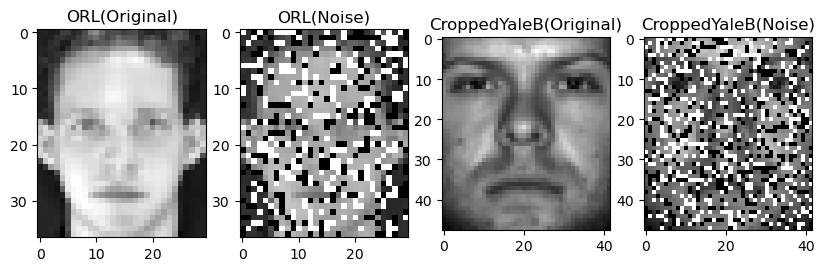

In [105]:
#salt and pepper
X_ORL_salt_pepper_noise = add_salt_pepper_noise(X_ORL,0.4)
X_YaleB_salt_pepper_noise = add_salt_pepper_noise(X_YaleB,0.4)

plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(X_ORL[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(X_ORL_salt_pepper_noise[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Noise)')
plt.subplot(143)
plt.imshow(X_YaleB[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original)')
plt.subplot(144)
plt.imshow(X_YaleB_salt_pepper_noise[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Noise)')
plt.show()

## $L_2$-Norm Based NMF

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.45253688109356704
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3000 (0.4764)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5538907646848062
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3333 (0.4453)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.44186957797978366
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3750 (0.5383)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5569241090274083
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3556 (0.4578)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.4558212339640982
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3083 (0.4800)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5484186868501433
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3250 (0.4279)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.4485862271152702
==> Evaluate Acc and NMI ...
Acc

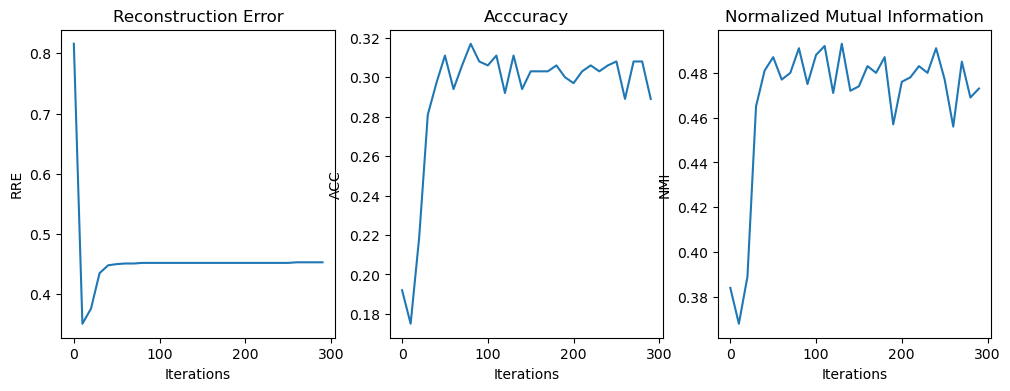

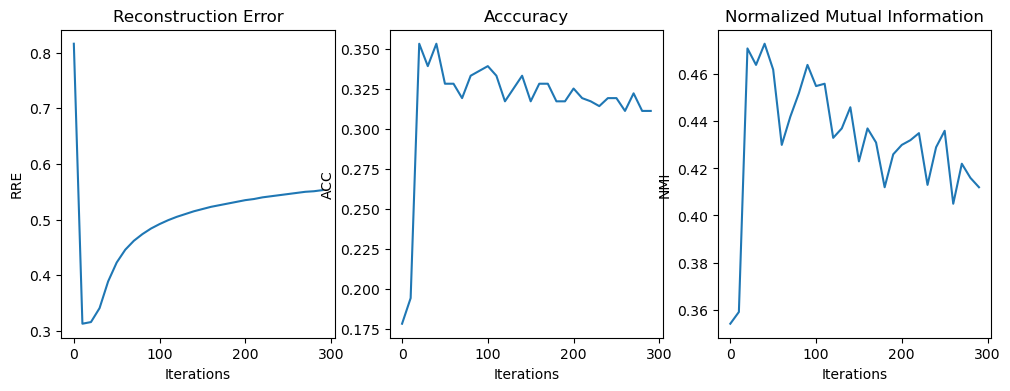

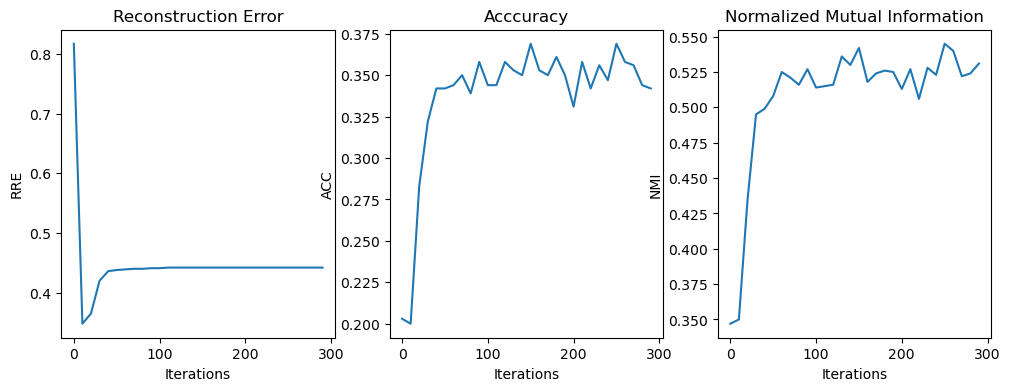

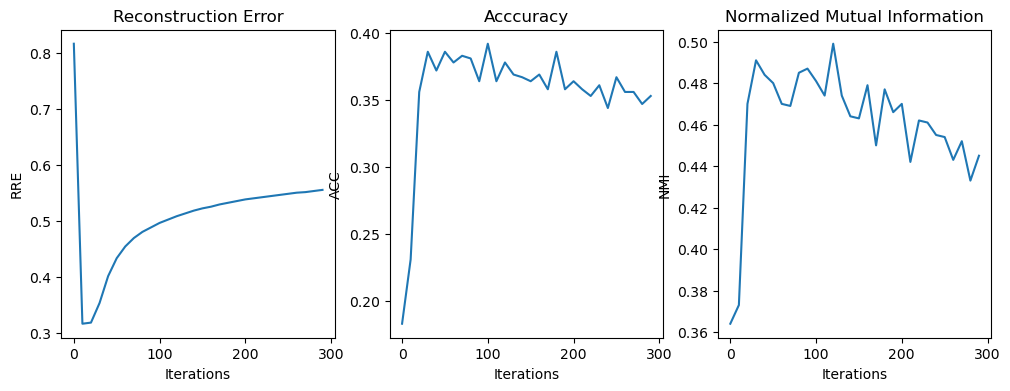

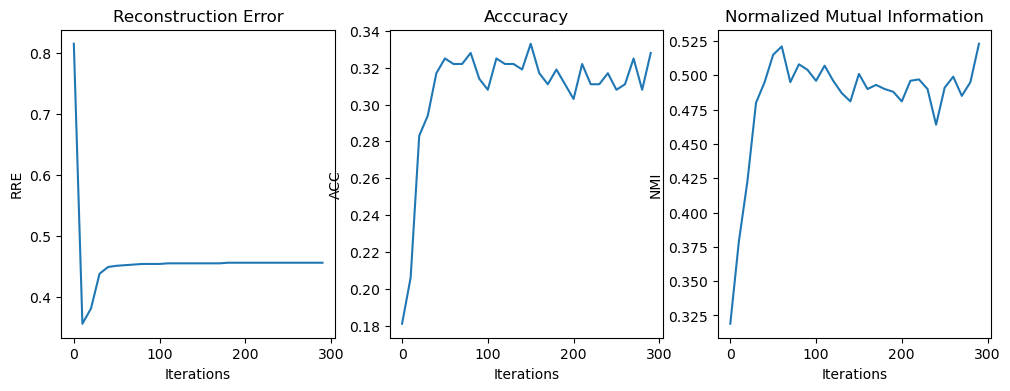

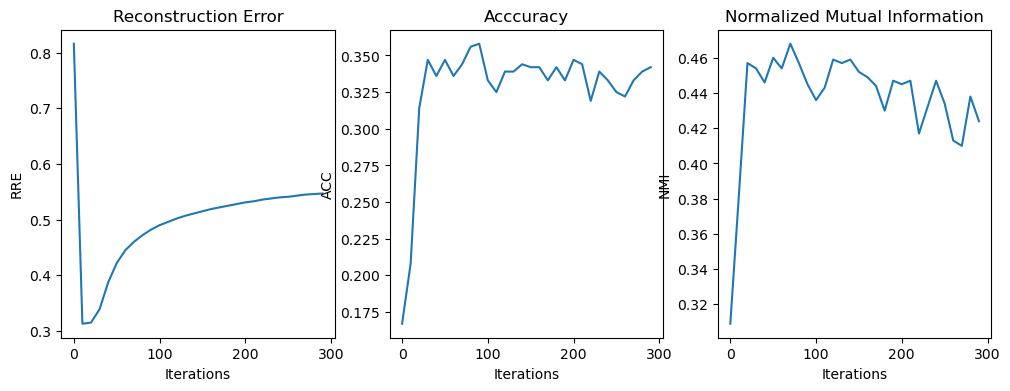

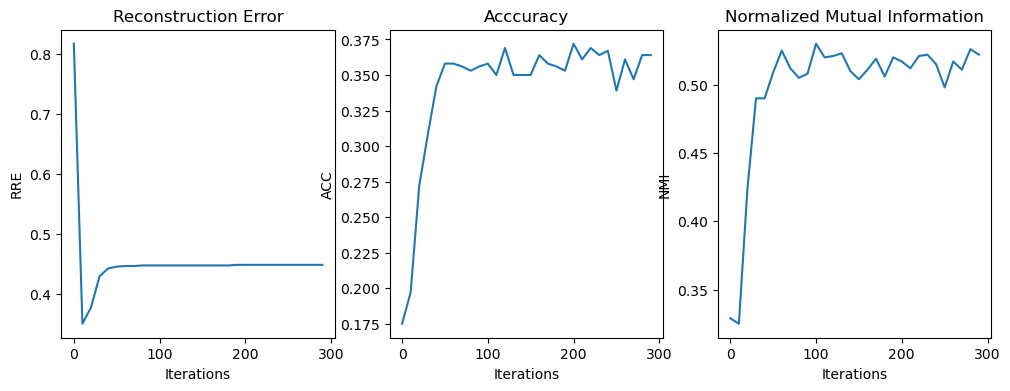

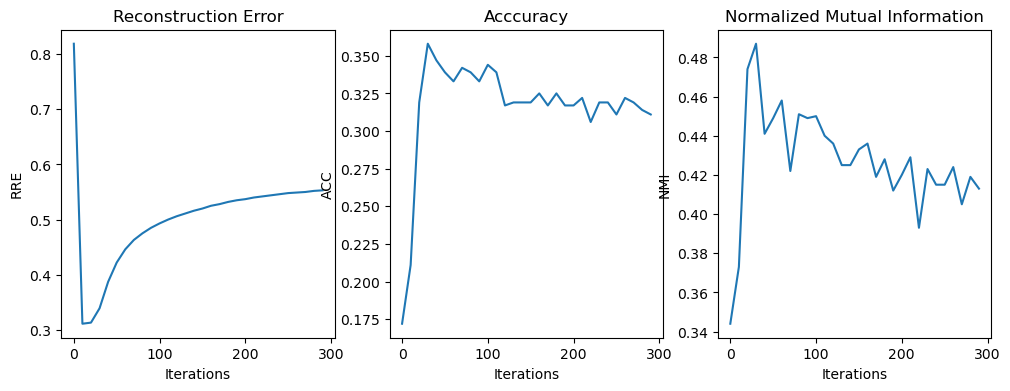

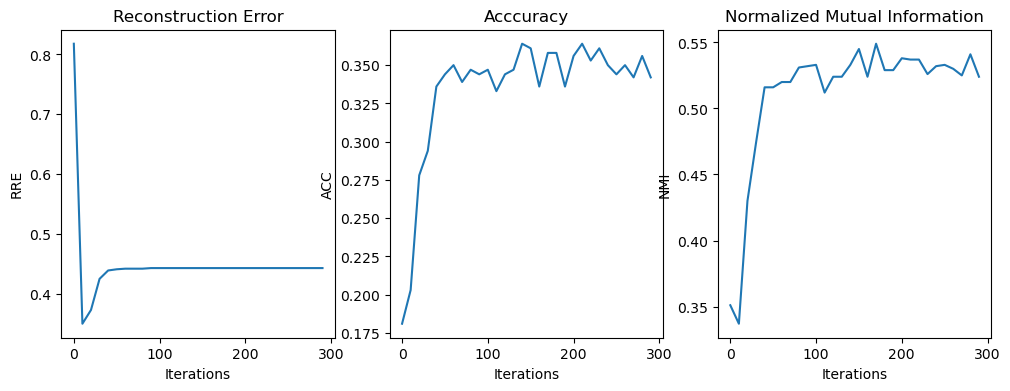

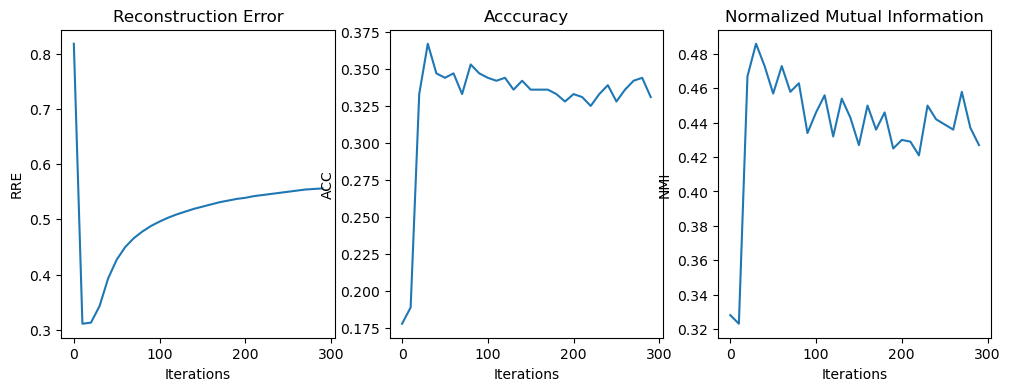

In [106]:
l2_W_estimate_b, l2_H_estimate_b, l2_W_estimate_sp, l2_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl2_NMF("X_ORL",X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL,300)

### Image of Original image and reconstructed image for both noised image

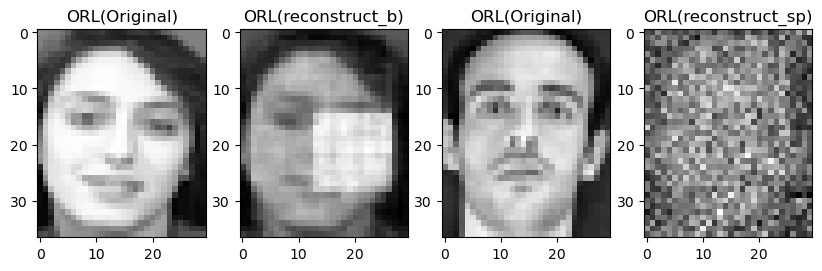

In [107]:
ORL_reconstruct_b=reconstruct(l2_W_estimate_b, l2_H_estimate_b)
ORL_reconstruct_sp=reconstruct(l2_W_estimate_sp, l2_H_estimate_sp)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6131548307529067
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1252 (0.1563)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5856236865303047
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1137 (0.1053)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6234407510895238
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1257 (0.1606)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5813131247353559
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1050 (0.0955)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6441787294527032
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1298 (0.1503)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.578190989550905
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1077 (0.1067)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6286420929213379
==> Evaluate Acc and NMI ...
Acc(NM

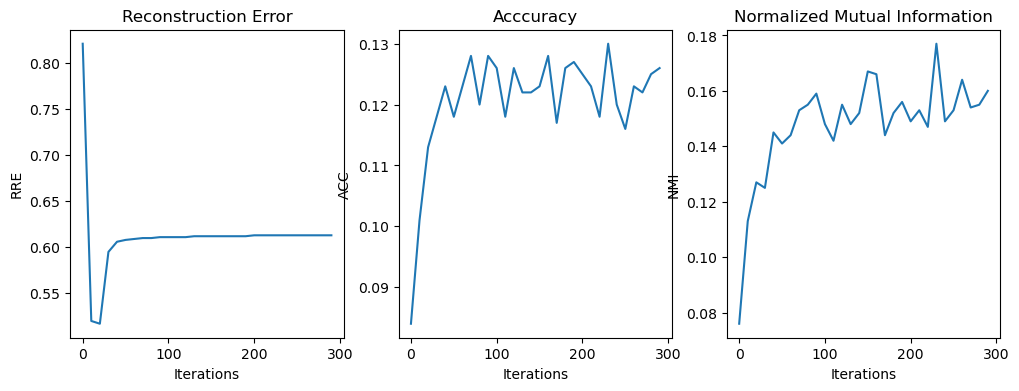

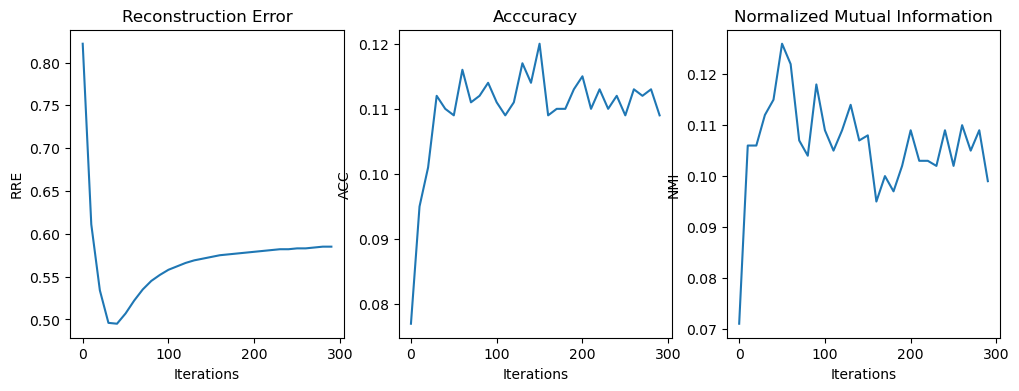

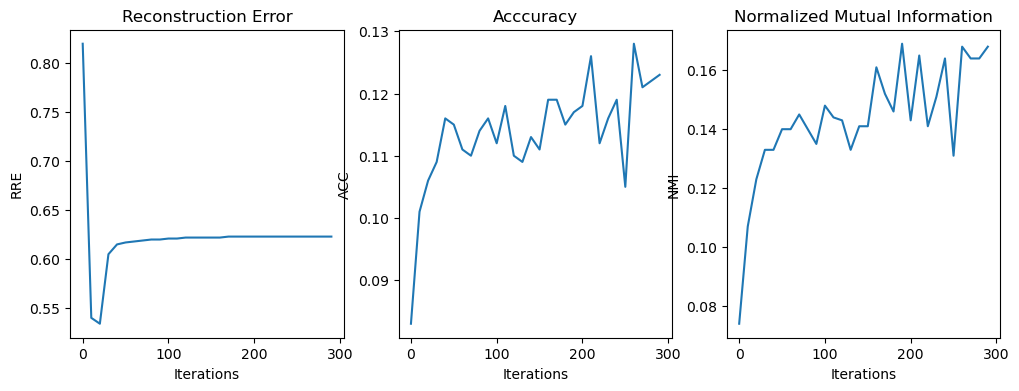

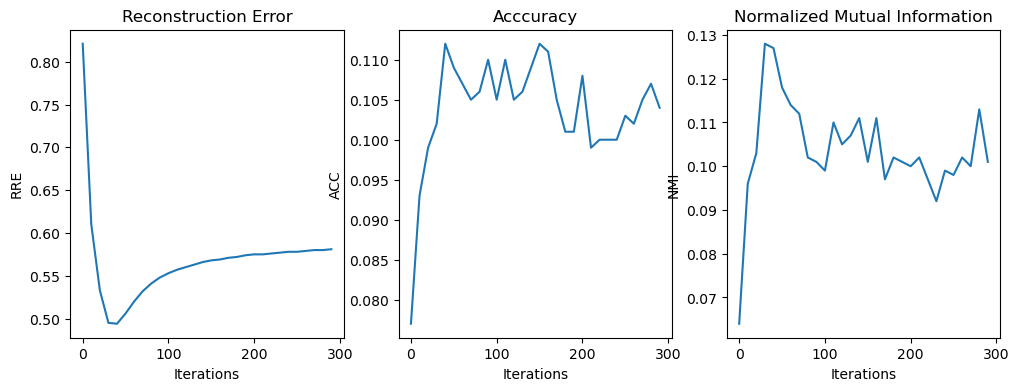

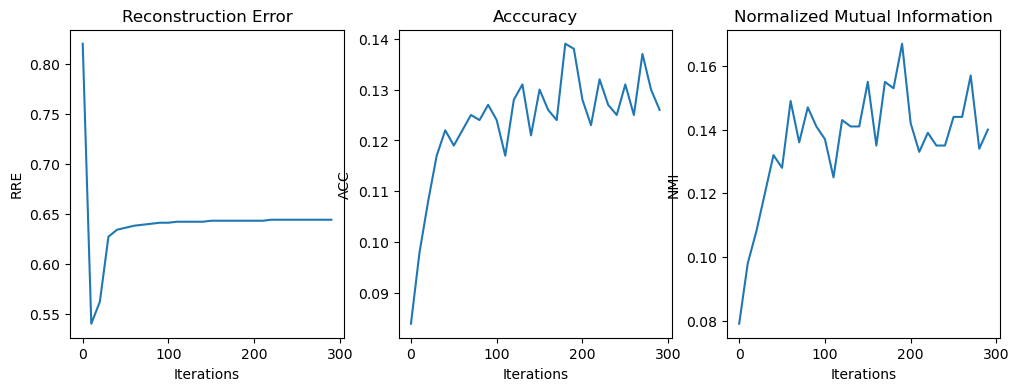

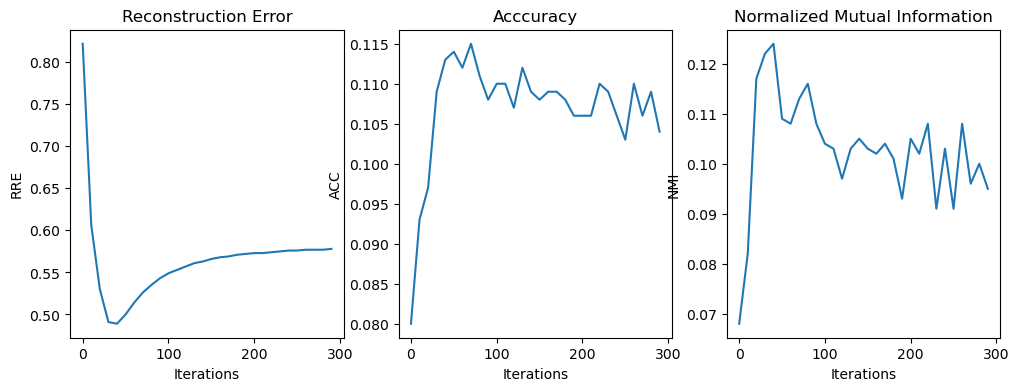

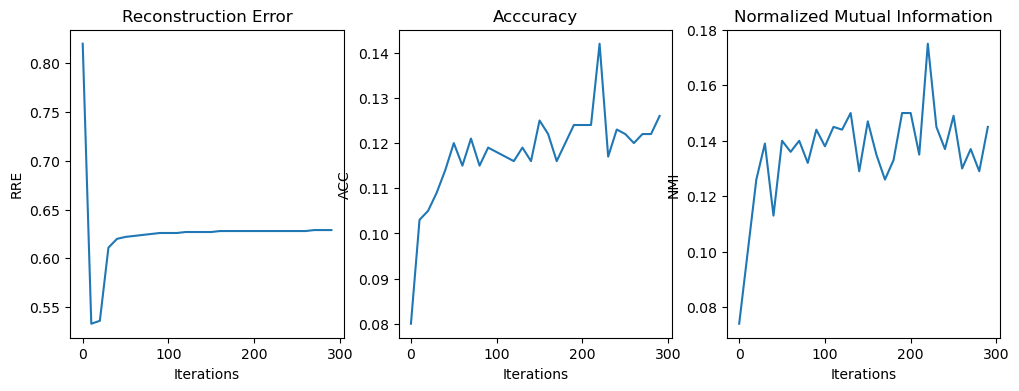

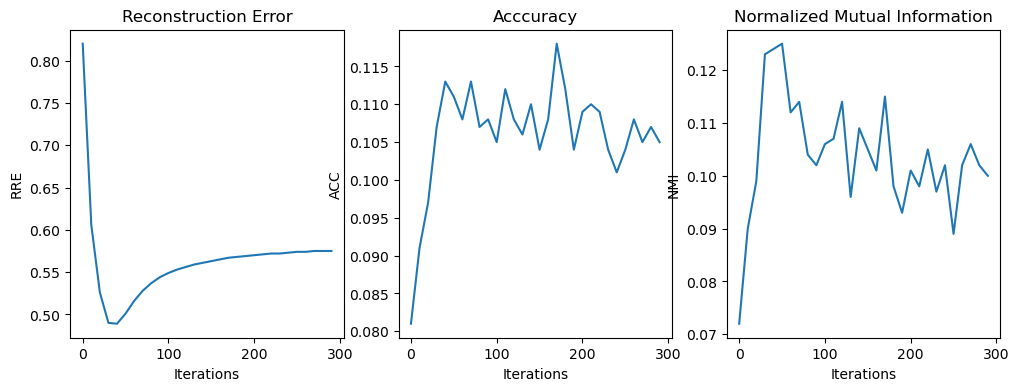

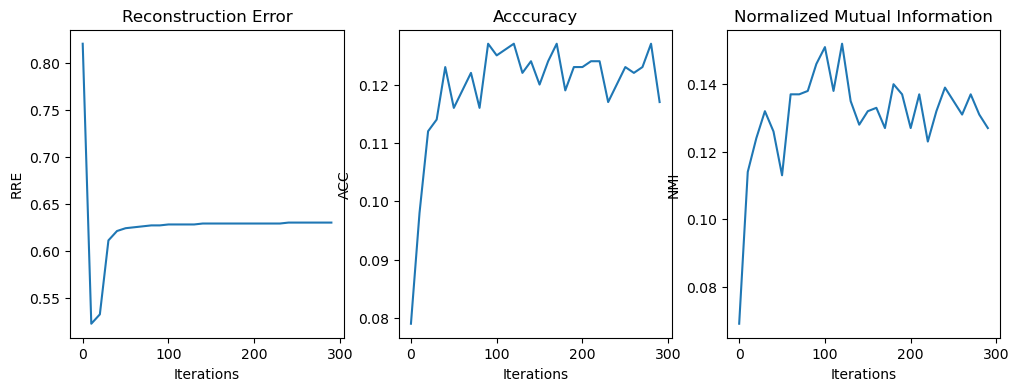

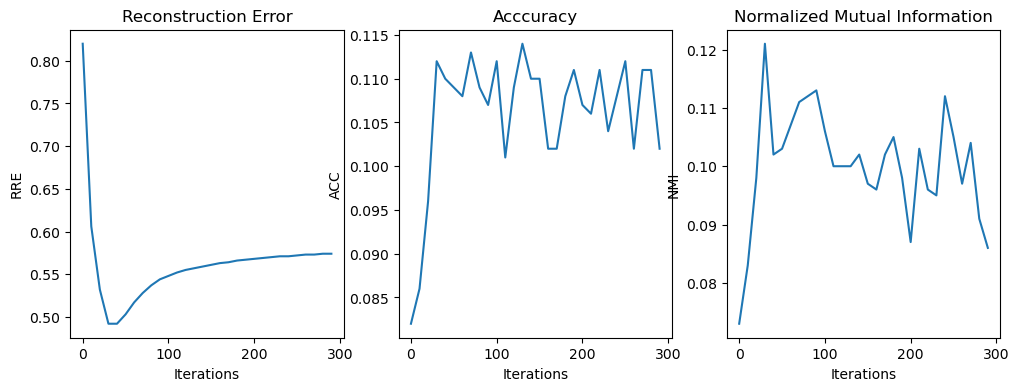

In [108]:
l2_W_estimate_b, l2_H_estimate_b, l2_W_estimate_sp, l2_H_estimate_sp,sample_ori_b,sample_ori_sp= experimentl2_NMF("X_YaleB",X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB,300)

### Image of Original image and reconstructed image for both noised image

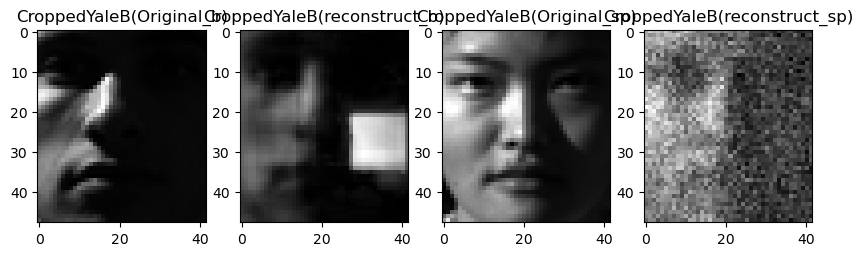

In [109]:
YaleB_reconstruct_b=reconstruct(l2_W_estimate_b, l2_H_estimate_b)
YaleB_reconstruct_sp=reconstruct(l2_W_estimate_sp, l2_H_estimate_sp)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(YaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(YaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()

## $L_{2,1}$-Norm Based NMF

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.44066191459492604
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3556 (0.5320)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5308570780073372
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3083 (0.4074)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.4456125955011714
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3278 (0.4726)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5461047701318298
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2944 (0.3891)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.44191252967110406
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3194 (0.5046)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5384859742625233
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2806 (0.3767)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.446352844934292
==> Evaluate Acc and NMI ...
Acc(

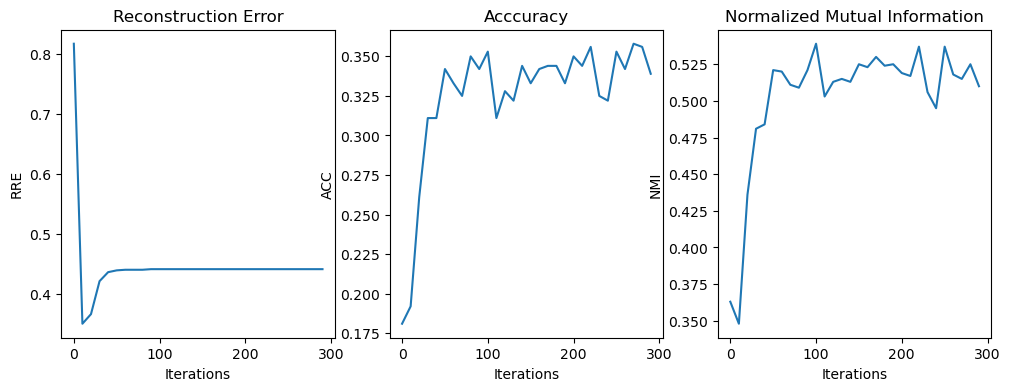

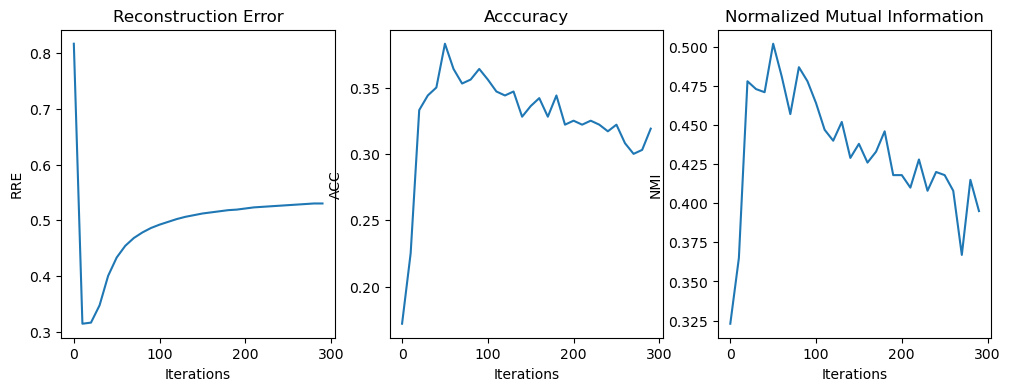

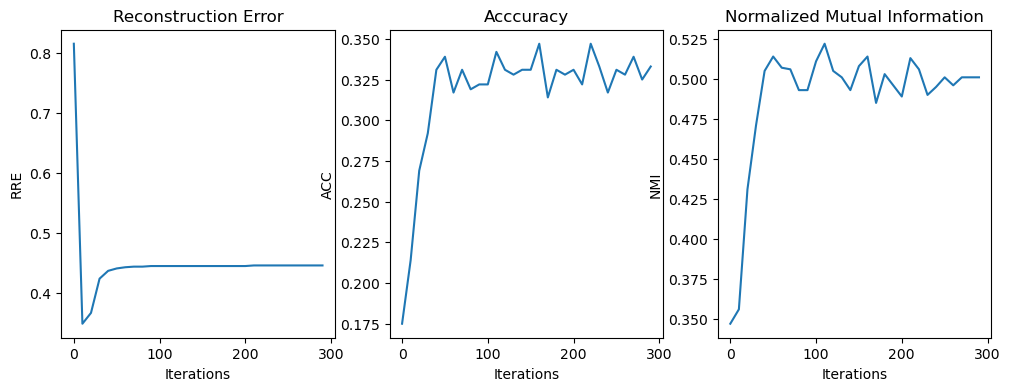

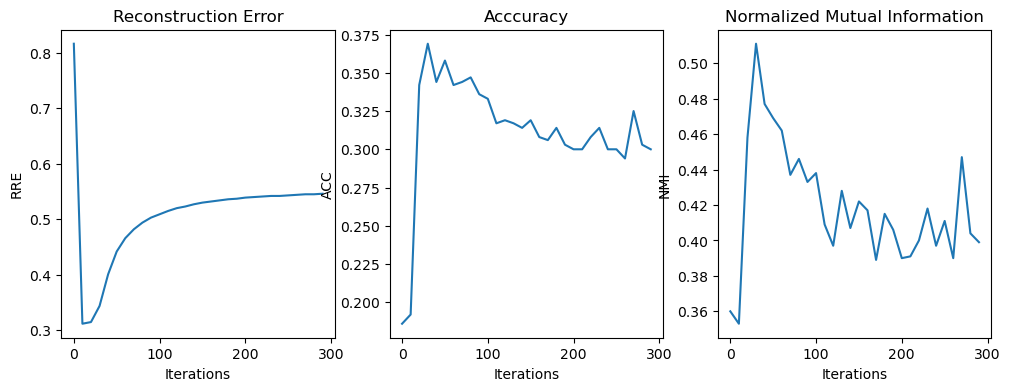

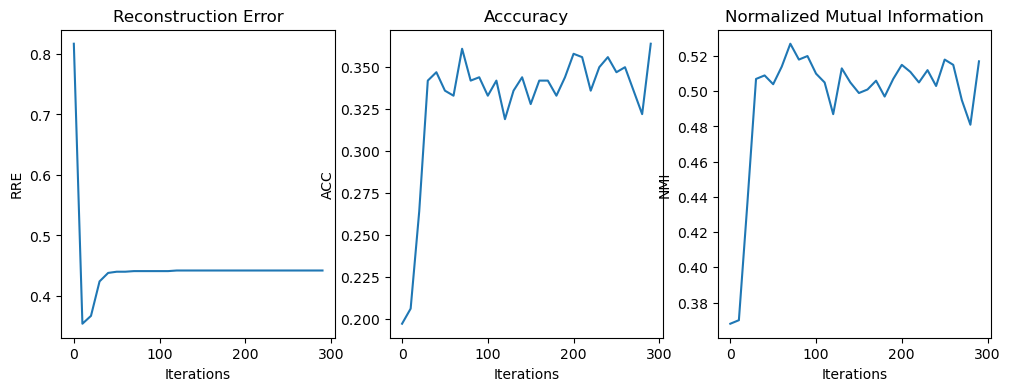

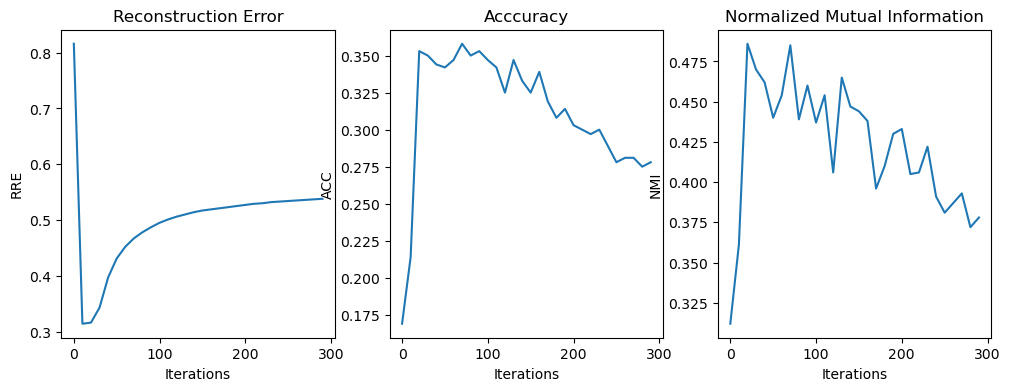

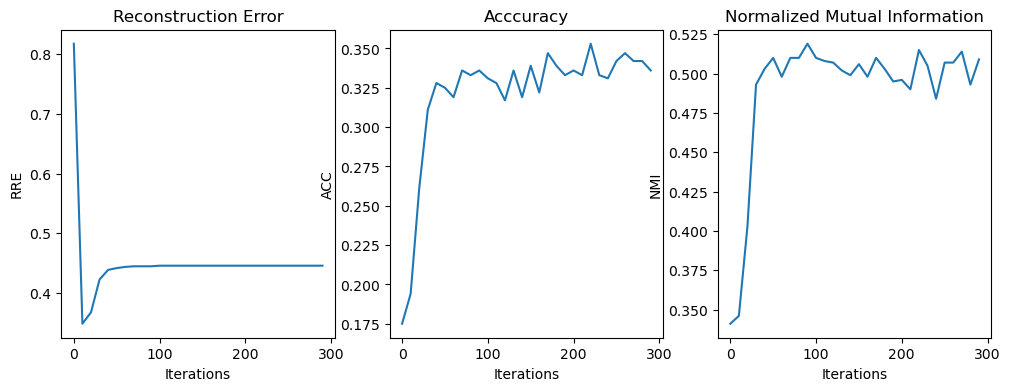

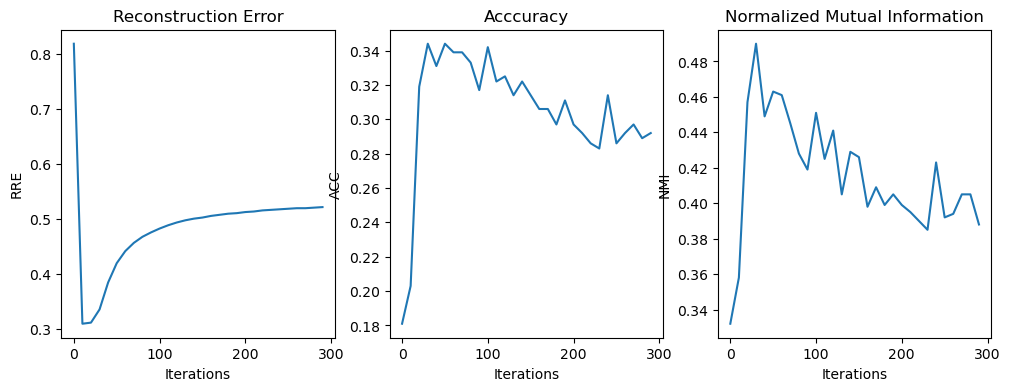

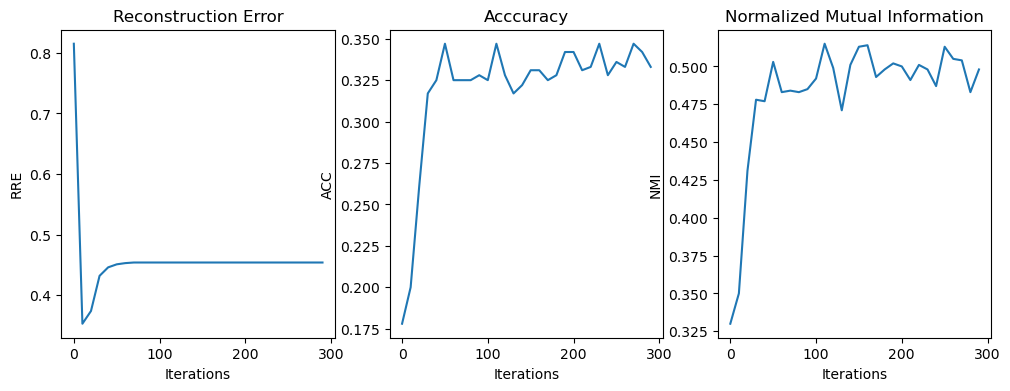

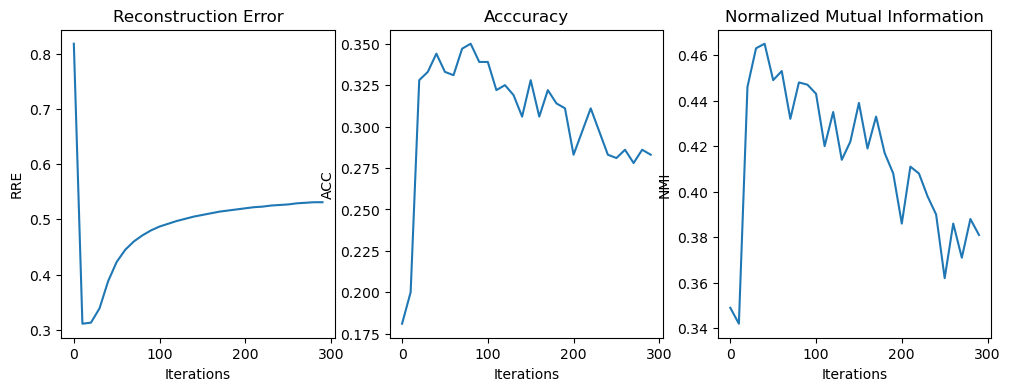

In [110]:
l21_W_estimate_b, l21_H_estimate_b, l21_W_estimate_sp, l21_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl21_NMF("X_ORL",X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL,300)

### Image of Original image and reconstructed image for both noised image

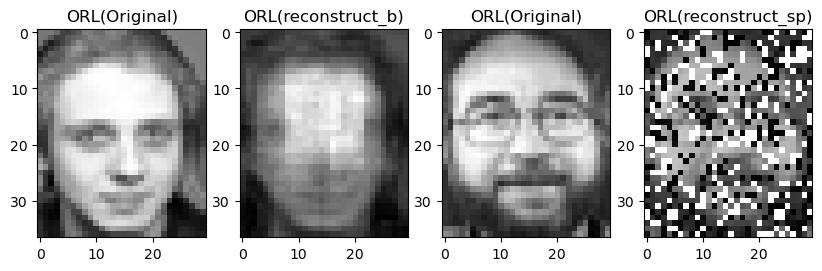

In [111]:
ORL_reconstruct_b=reconstruct(l21_W_estimate_b, l21_H_estimate_b)
ORL_reconstruct_sp=reconstruct(l21_W_estimate_sp, l21_H_estimate_sp)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6256039513758133
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1179 (0.1372)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.581967420651572
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1100 (0.1063)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6327077827448959
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1289 (0.1479)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.578467887058951
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1068 (0.0954)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6385041915055861
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1344 (0.1788)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.5771979219012034
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1077 (0.1052)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.6279304233049253
==> Evaluate Acc and NMI ...
Acc(NMI

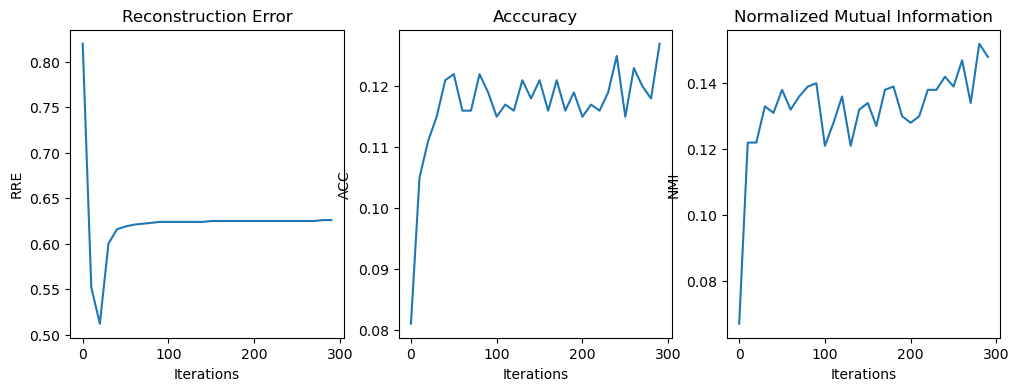

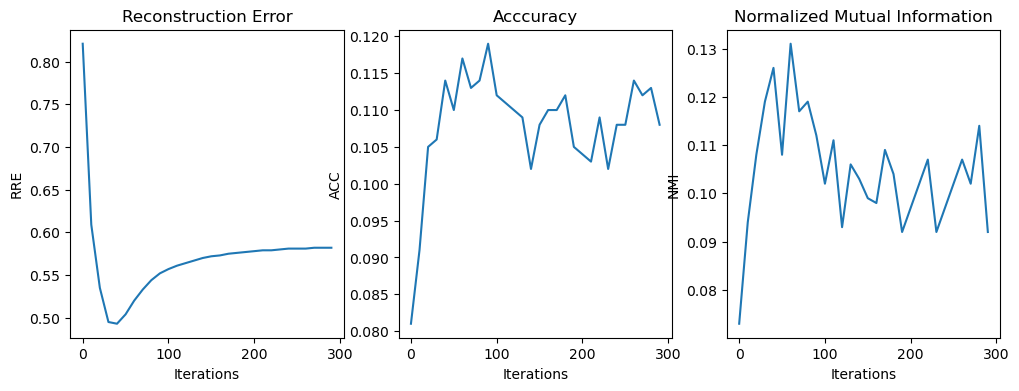

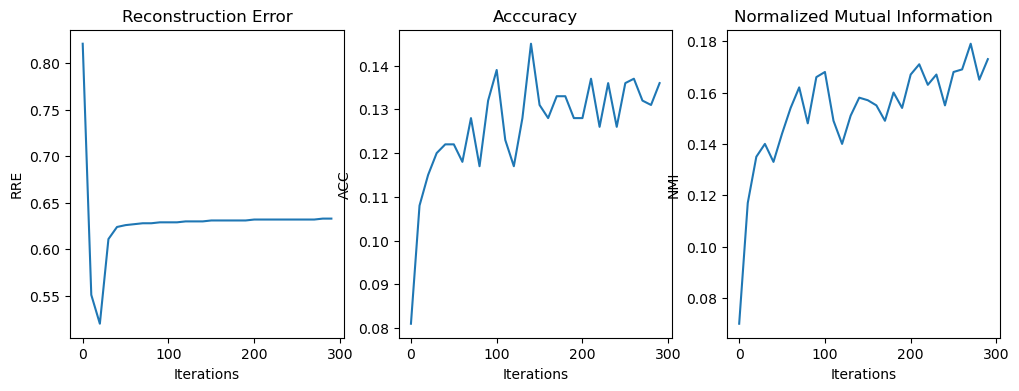

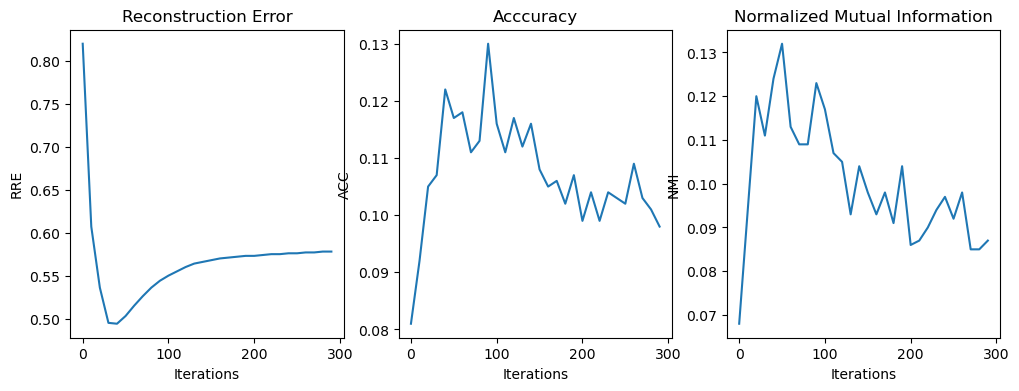

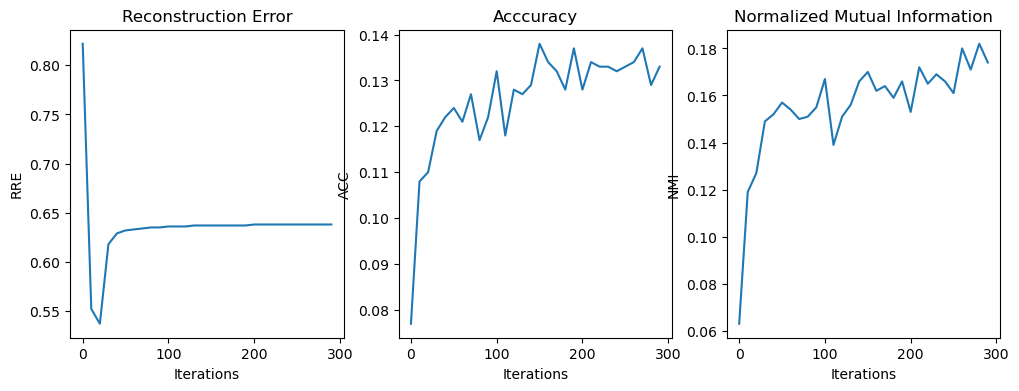

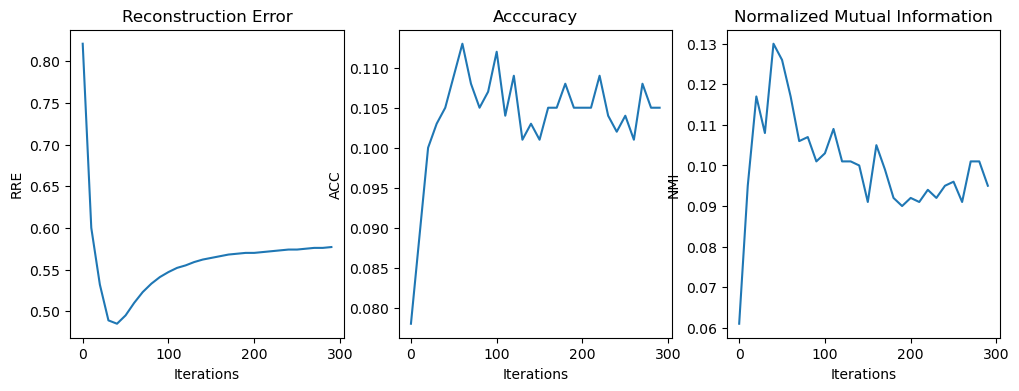

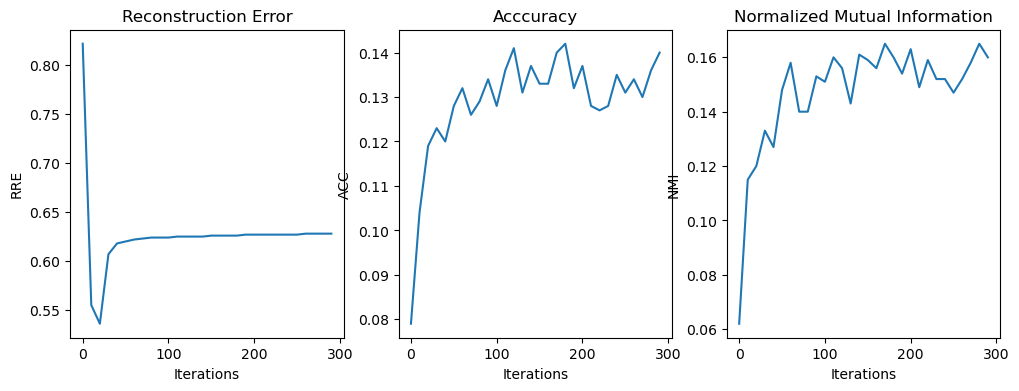

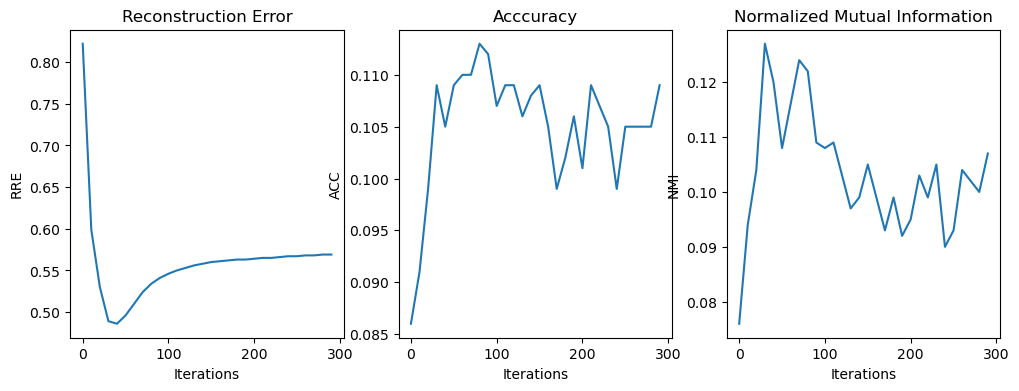

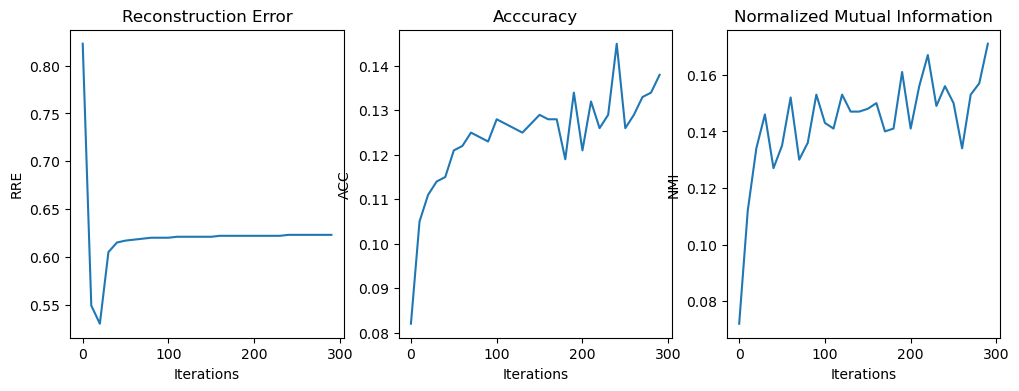

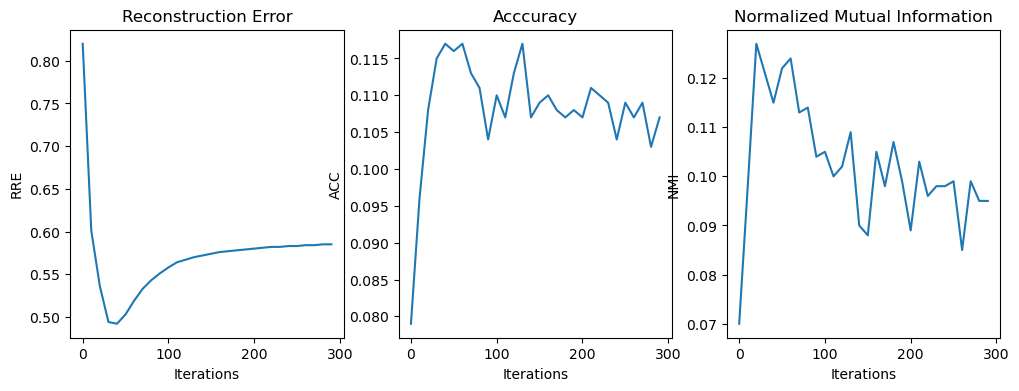

In [112]:
l21_W_estimate_b, l21_H_estimate_b, l21_W_estimate_sp, l21_H_estimate_sp,sample_ori_b,sample_ori_sp=experimentl21_NMF("X_YaleB",X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB,300)

### Image of Original image and reconstructed image for both noised image

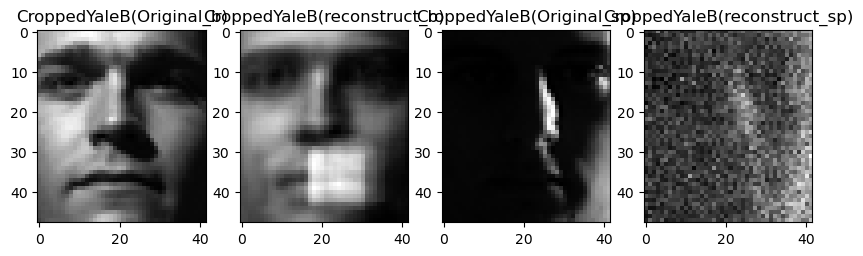

In [113]:
YaleB_reconstruct_b=reconstruct(l21_W_estimate_b, l21_H_estimate_b)
YaleB_reconstruct_sp=reconstruct(l21_W_estimate_sp, l21_H_estimate_sp)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(YaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(YaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()

## CIM Non-negative Matrix Factorization 

### ORL dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.3204020028357929
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5000 (0.6622)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.39014347304732094
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4028 (0.5808)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.314374932482992
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4889 (0.6471)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.38363428955580786
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4139 (0.6114)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.31242209083230194
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5056 (0.6610)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.4107676700467795
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.4056 (0.5903)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.32430324693960194
==> Evaluate Acc and NMI ...
Ac

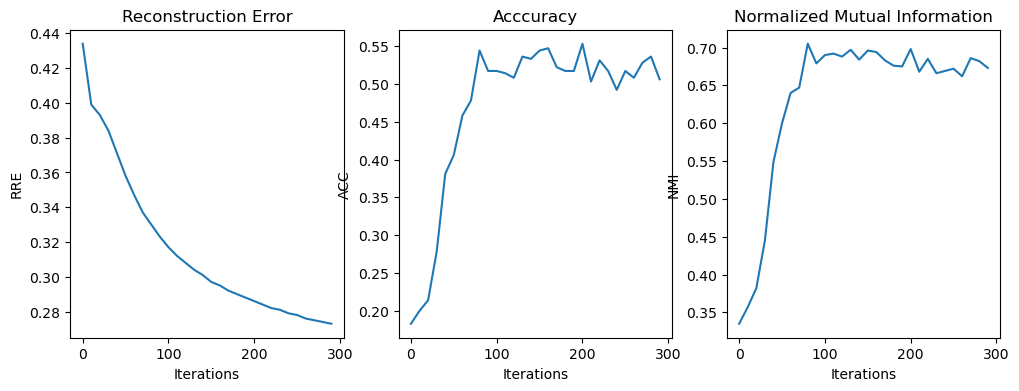

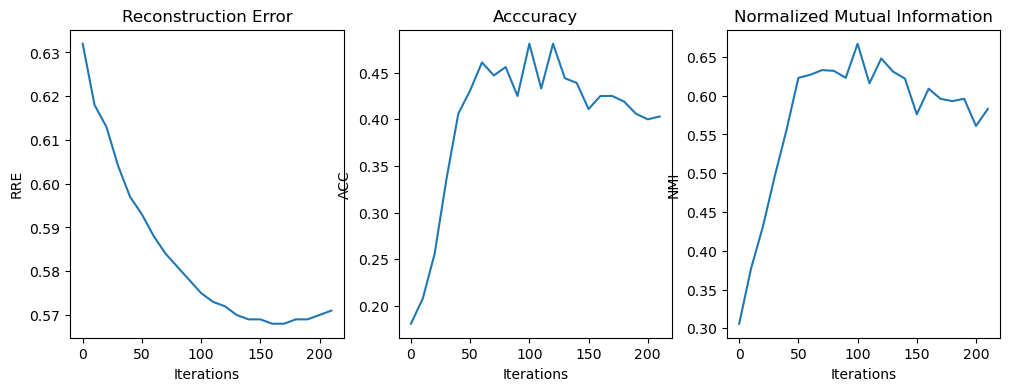

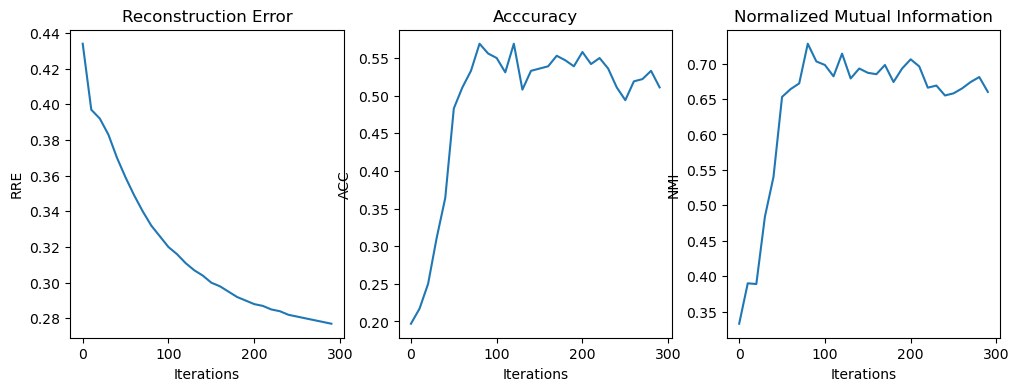

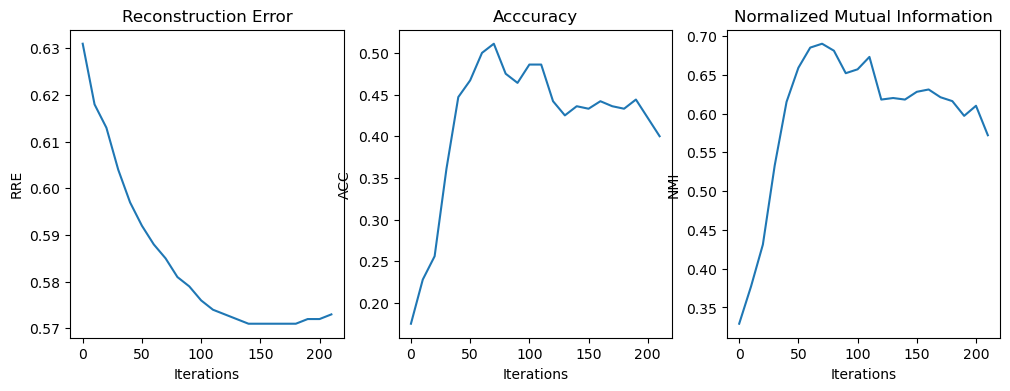

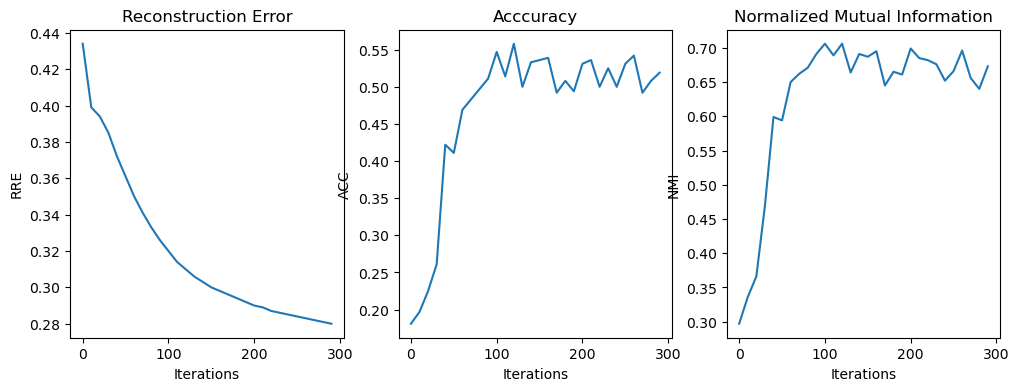

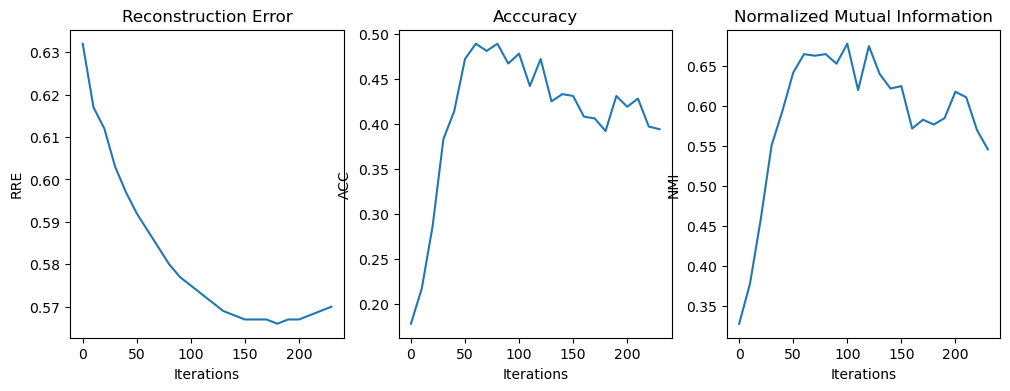

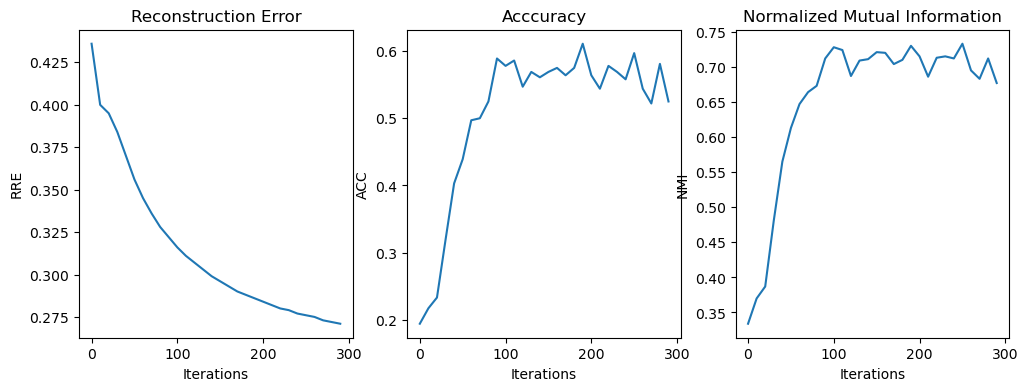

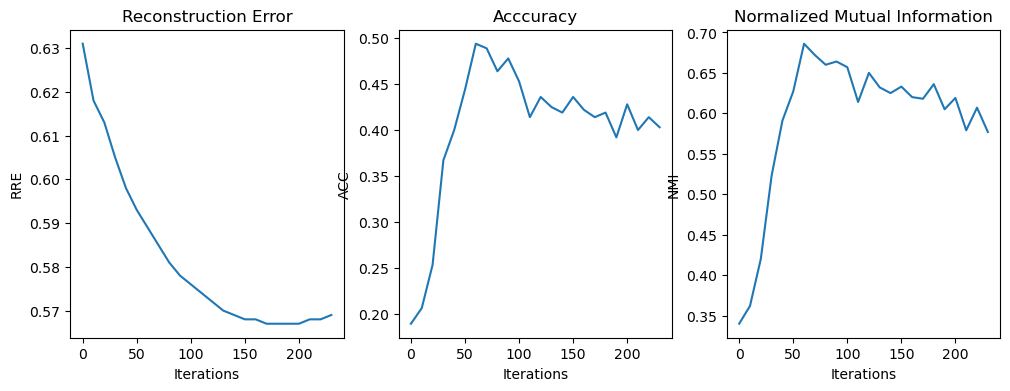

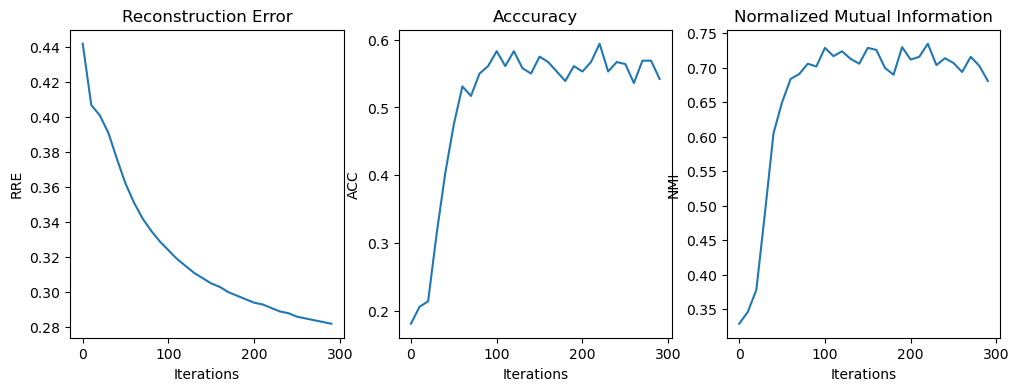

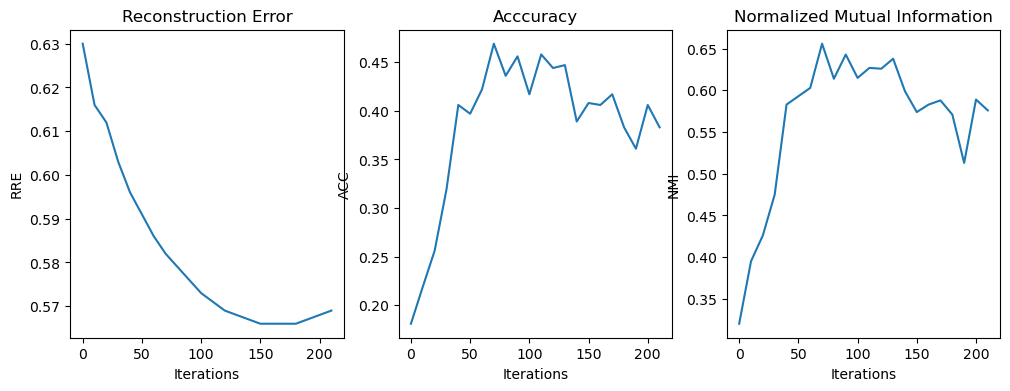

In [114]:
W_estimate_block, H_estimate_block, W_estimate_salt, H_estimate_salt, sample_ori_b,sample_ori_sp = experiment_CIM_NMF(
    X_ORL_block_noise,X_ORL_salt_pepper_noise,Y_ORL, data = "ORL")

### Image of Original image and reconstructed image for both noised image

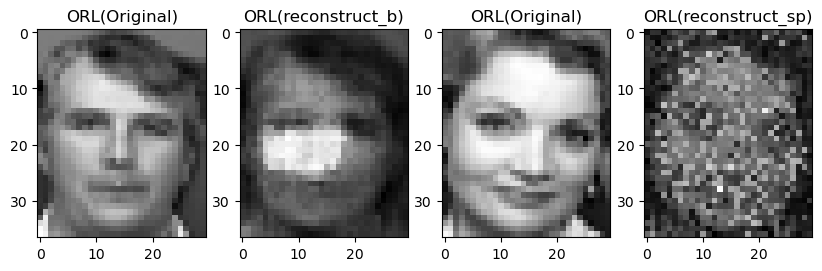

In [115]:
# show image for ORL
ORL_reconstruct_b=reconstruct(W_estimate_block, H_estimate_block)
ORL_reconstruct_sp=reconstruct(W_estimate_salt, H_estimate_salt)
plt.figure(figsize=(10,4))

plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(142)
plt.imshow(ORL_reconstruct_b[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_b)')

plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(Original)')
plt.subplot(144)
plt.imshow(ORL_reconstruct_sp[:,0].reshape(37,30), cmap=plt.cm.gray)
plt.title('ORL(reconstruct_sp)')
plt.show()

### YaleB Dataset

current run 1
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23634046217887164
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2928 (0.3525)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2597021771926279
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1897 (0.2544)


current run 2
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.23679288427138104
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2721 (0.3334)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2574666639694791
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1989 (0.2595)


current run 3
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.24209133556865378
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.2634 (0.3180)
Evaluetion of salt and peppered image
==> Evaluate RRE ...
RRE = 0.2601410940024123
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.1952 (0.2539)


current run 4
Evaluetion of block noised image
==> Evaluate RRE ...
RRE = 0.22744468867026021
==> Evaluate Acc and NMI ...
A

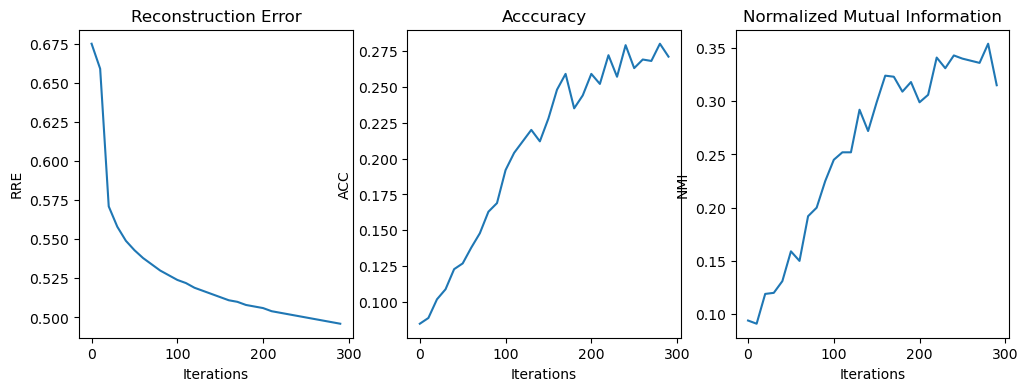

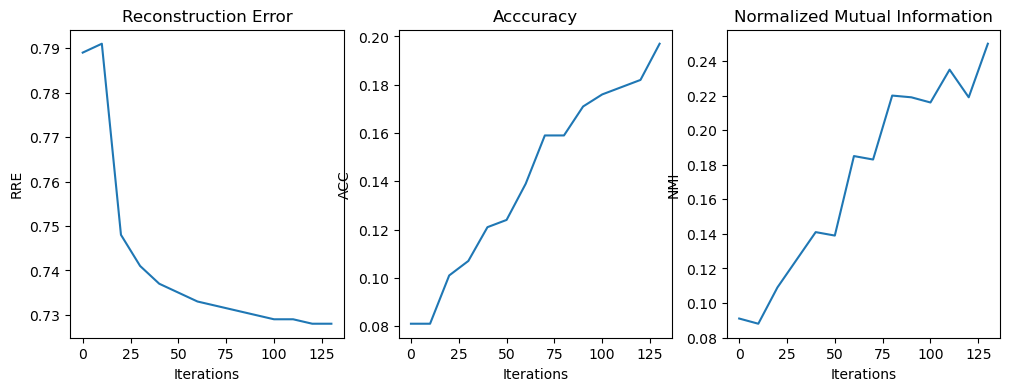

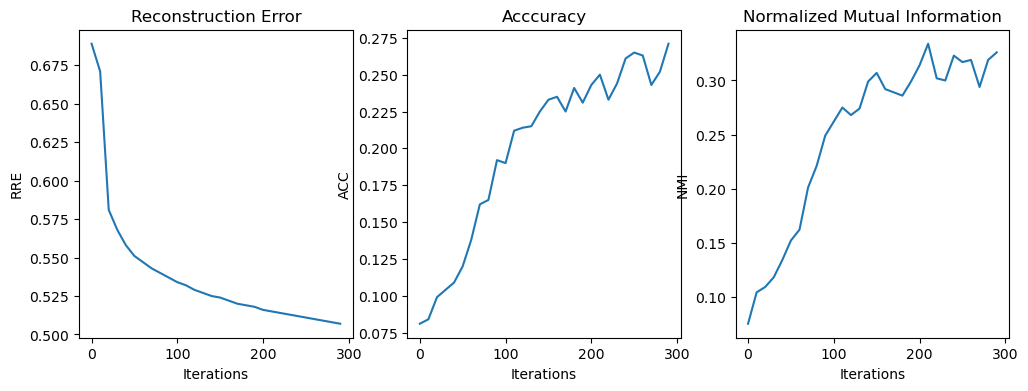

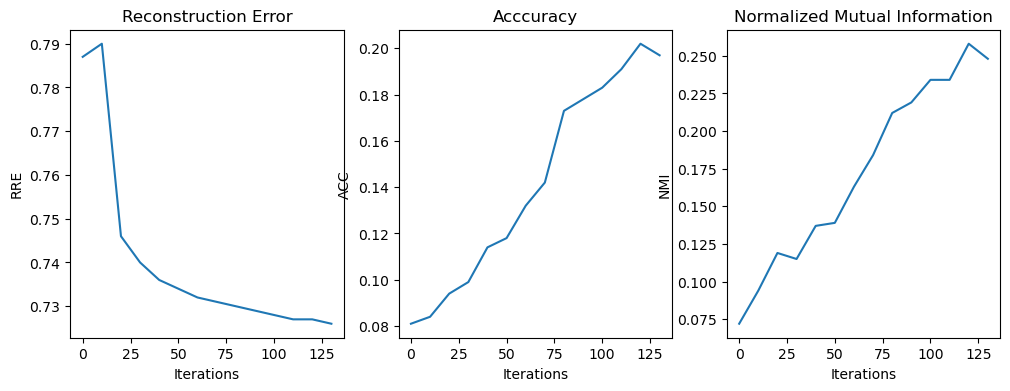

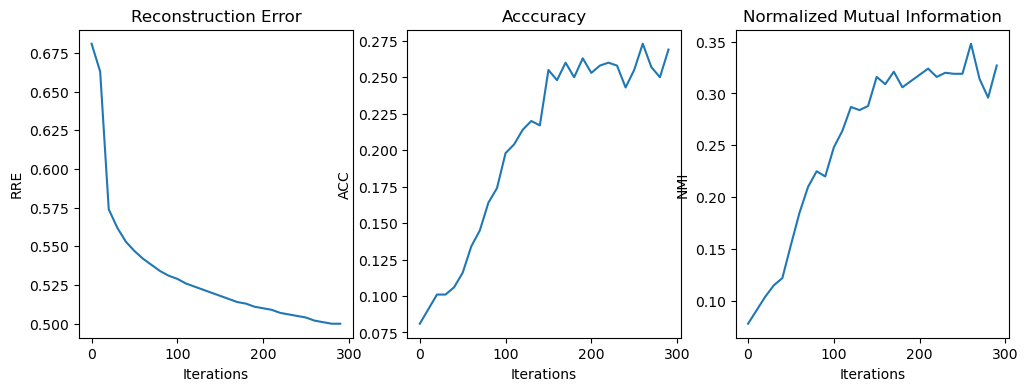

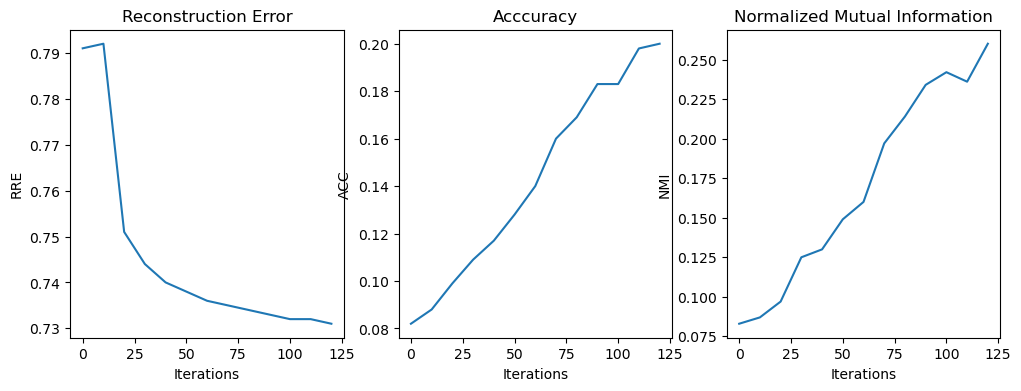

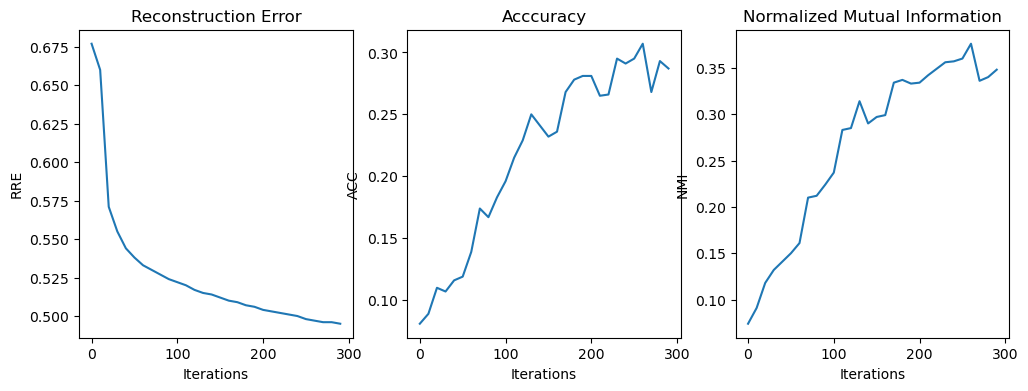

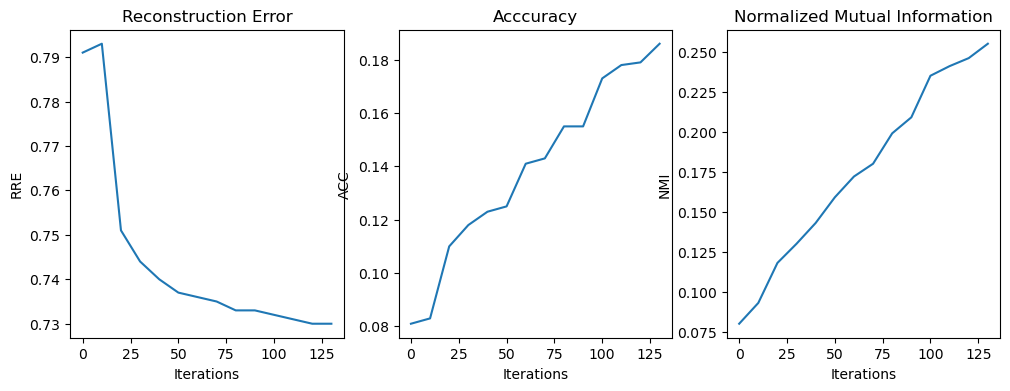

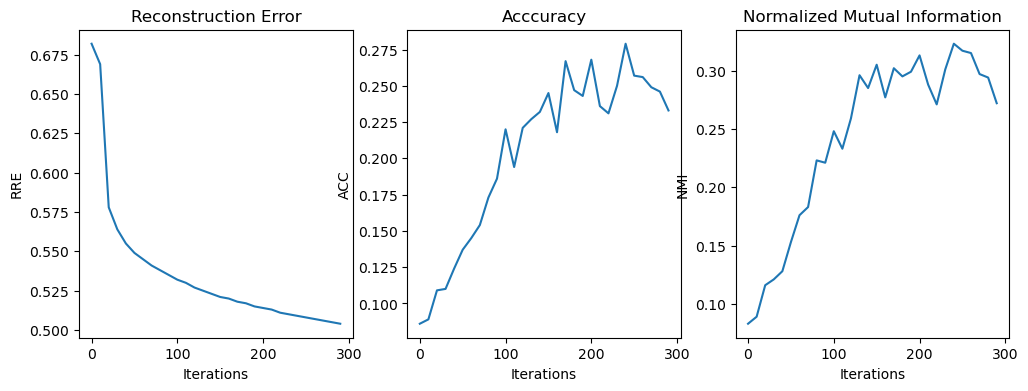

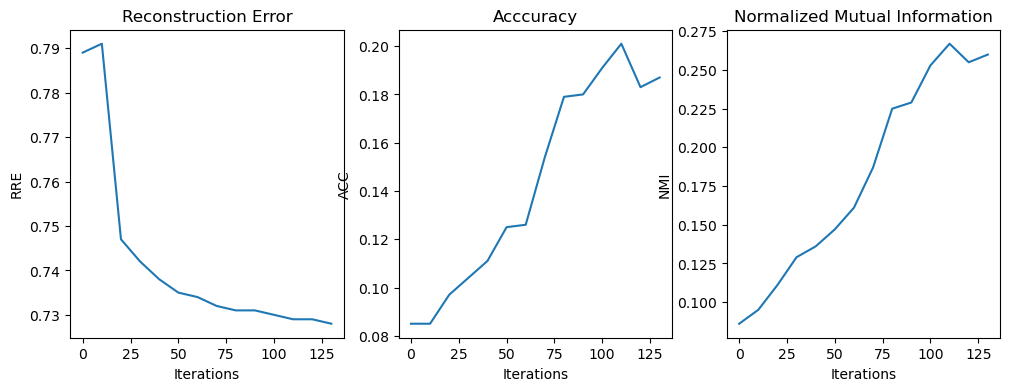

In [116]:
W_estimate_block, H_estimate_block, W_estimate_salt, H_estimate_salt,sample_ori_b,sample_ori_sp = experiment_CIM_NMF(
    X_YaleB_block_noise,X_YaleB_salt_pepper_noise,Y_YaleB, data = "YaleB")

### Image of Original image and reconstructed image for both noised image

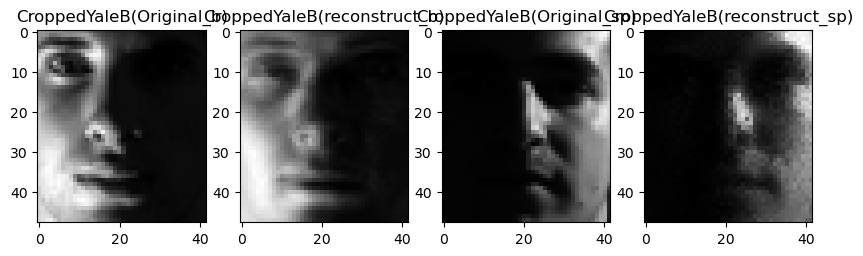

In [117]:
# show image for YaleB
yaleB_reconstruct_b=reconstruct(W_estimate_block, H_estimate_block)
yaleB_reconstruct_sp=reconstruct(W_estimate_salt, H_estimate_salt)
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(sample_ori_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_b)')
plt.subplot(142)
plt.imshow(yaleB_reconstruct_b[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_b)')
plt.subplot(143)
plt.imshow(sample_ori_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(Original_sp)')
plt.subplot(144)
plt.imshow(yaleB_reconstruct_sp[:,0].reshape(48, 42), cmap=plt.cm.gray)
plt.title('CroppedYaleB(reconstruct_sp)')
plt.show()